In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys, os
BASE = os.getcwd()  
if BASE not in sys.path:
    sys.path.append(BASE)

from funcs import *          
from funcs import utils    


In [2]:
img_size = 928//2
ext_mm = img_size * (400/928)/2
extent = [-ext_mm, ext_mm, -ext_mm, ext_mm]  # [xmin, xmax, ymin, ymax]

def save_and_plot_height_reflectance(
    obj_name: str,
    data_path: str,
    ref_path: str,
    img_size,
    extent,
    net_idx: int = 0,
    max_height_mm: float = 100.0,
    show: bool = True,
    save_pic: int = 0,  
    dpi: int = 600,
):
    """
    Load predicted height & reflectance, normalize, optionally save as PNG, and plot.

    Args:
        obj_name: object name, e.g. 'cup', 'box'
        data_path: path to epoch_xxxx/
        img_size: target crop size
        extent: (xmin, xmax, ymin, ymax) in mm for plotting
        net_idx: which network index to load
        max_height_mm: height normalization upper bound (default 100 mm)
        show: whether to show matplotlib figures
        save_pic: 0 (default) = do NOT save png, 1 = save png
        dpi: figure DPI
    """

    # ================= Load & preprocess =================
    height = crop_to_size(
        np.flipud(
            np.load(f'{data_path}net_{net_idx}_pred_h.npy')
        ),
        img_size
    )

    reflec = crop_to_size(
        np.flipud(
            np.transpose(
                np.load(f'{data_path}net_{net_idx}_pred_r.npy'),
                (1, 2, 0)
            )
        ),
        img_size
    )
    
    ref_height = np.load(f'{ref_path}{obj_name}_interp_height_world.npy')
    ref_height = np.flipud(ref_height)   # (H, W)

    # ===== resize to 1024 =====
    ref_height = cv2.resize(
        ref_height,
        (img_size*2, img_size*2),
        interpolation=cv2.INTER_LINEAR  
    )

    # ===== crop =====
    ref_height = crop_to_size(
        ref_height,
        img_size
    )

    ref_height = np.nan_to_num(ref_height)
    
    # ===== load & flip =====
    ref_reflec = np.load(f'{ref_path}{obj_name}_interp_rgb_albedo_world.npy')
    ref_reflec = np.flipud(ref_reflec)   # (H, W, 3)

    # ===== resize to 1024 =====
    ref_reflec = cv2.resize(
        ref_reflec,
        (img_size*2, img_size*2),
        interpolation=cv2.INTER_LINEAR  
    )

    # ===== crop to img_size =====
    ref_reflec = crop_to_size(
        ref_reflec,
        img_size
    )
    ref_reflec = np.nan_to_num(ref_reflec)

    ref_reflec = crop_to_size(ref_reflec, img_size, center=(256-25, 256-25))
    
    
    height_diff = ref_height - crop_to_size(height, img_size, center=(256-25, 256-25)) 

    fig = plt.figure(figsize=(10, 4), dpi=dpi)

    # ===== spatial uncertainty map =====
    plt.subplot(121)

    uncertainty_map = np.abs(height_diff)  

    print(np.mean(height_diff))
    plt.imshow(height_diff, cmap='jet')
    plt.colorbar()
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    # plt.title('Height uncertainty map')

    # ===== CDF of uncertainty =====
    plt.subplot(122)

    data = uncertainty_map.ravel()
    data = data[np.isfinite(data)]          

    hist, bin_edges = np.histogram(
        data,
        bins=321,
        range=(0, data.max()),             
        density=True
    )

    cdf = np.cumsum(hist * np.diff(bin_edges))
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    plt.plot(bin_centers, cdf, linewidth=2)

    plt.xlabel('Height uncertainty (mm)')   
    plt.ylabel('Cumulative probability')
    plt.ylim(0, 1)
    plt.xlim(0, 10)                           

    plt.tight_layout()
    plt.show()
    
    threshold = 4.0  # mm

    data = uncertainty_map.ravel()
    data = data[np.isfinite(data)]

    ratio = np.mean(data <= threshold)

    print(f"CDF(error < {threshold:.1f} mm) = {ratio*100:.2f}%")


    reflec_diff = ref_reflec - reflec

    fig = plt.figure(figsize=(10, 4), dpi=dpi)

    # ===== spatial map =====
    plt.subplot(121)
    plt.imshow(reflec_diff, cmap='jet')
#     plt.colorbar()
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')

    # ===== CDF =====
    plt.subplot(122)

    data = reflec_diff.ravel()
    hist, bin_edges = np.histogram(data, bins=41, density=True)
    cdf = np.cumsum(hist * np.diff(bin_edges))

    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    plt.plot(bin_centers, cdf, linewidth=2)
    plt.xlabel('Reflectance difference')
    plt.ylabel('Cumulative probability')
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

    # ================= Visualization =================
    if show:
        fig = plt.figure(figsize=(10, 4), dpi=dpi)

        plt.subplot(121)
        plt.imshow(height, cmap='jet', extent=extent,
                   vmin=0, vmax=max_height_mm)
        plt.colorbar()
        plt.xlabel('x (mm)')
        plt.ylabel('y (mm)')
#         plt.title(f'{obj_name} Height (mm)')

        plt.subplot(122)
        plt.imshow(reflec, cmap='gray', extent=extent,
                   vmin=0, vmax=1)
#         plt.colorbar()
        plt.xlabel('x (mm)')
        plt.ylabel('y (mm)')
#         plt.title(f'{obj_name} Reflectance')

        plt.tight_layout()
        plt.show()
        
        fig = plt.figure(figsize=(10, 4), dpi=dpi)

        plt.subplot(121)
        plt.imshow(ref_height, cmap='jet', extent=extent,
                   vmin=0, vmax=max_height_mm)
        plt.colorbar()
        plt.xlabel('x (mm)')
        plt.ylabel('y (mm)')
        
        plt.subplot(122)
        plt.imshow(ref_reflec, cmap='jet', extent=extent,
                   vmin=0, vmax=max_height_mm)
#         plt.colorbar()
        plt.xlabel('x (mm)')
        plt.ylabel('y (mm)')
        
        plt.show()
        
        fig = plt.figure(figsize=(10, 4), dpi=dpi)

        plt.subplot(121)
        plt.imshow(ref_height, cmap='jet', extent=extent,
                   vmin=0, vmax=max_height_mm)
        plt.colorbar()
        plt.xlabel('x (mm)')
        plt.ylabel('y (mm)')
        
        plt.subplot(122)
        plt.imshow(height, cmap='jet', extent=extent,
                   vmin=0, vmax=max_height_mm)
        plt.colorbar()
        plt.xlabel('x (mm)')
        plt.ylabel('y (mm)')
        
        plt.show()
                   

    return height, reflec


# Box

0.47803913553275035


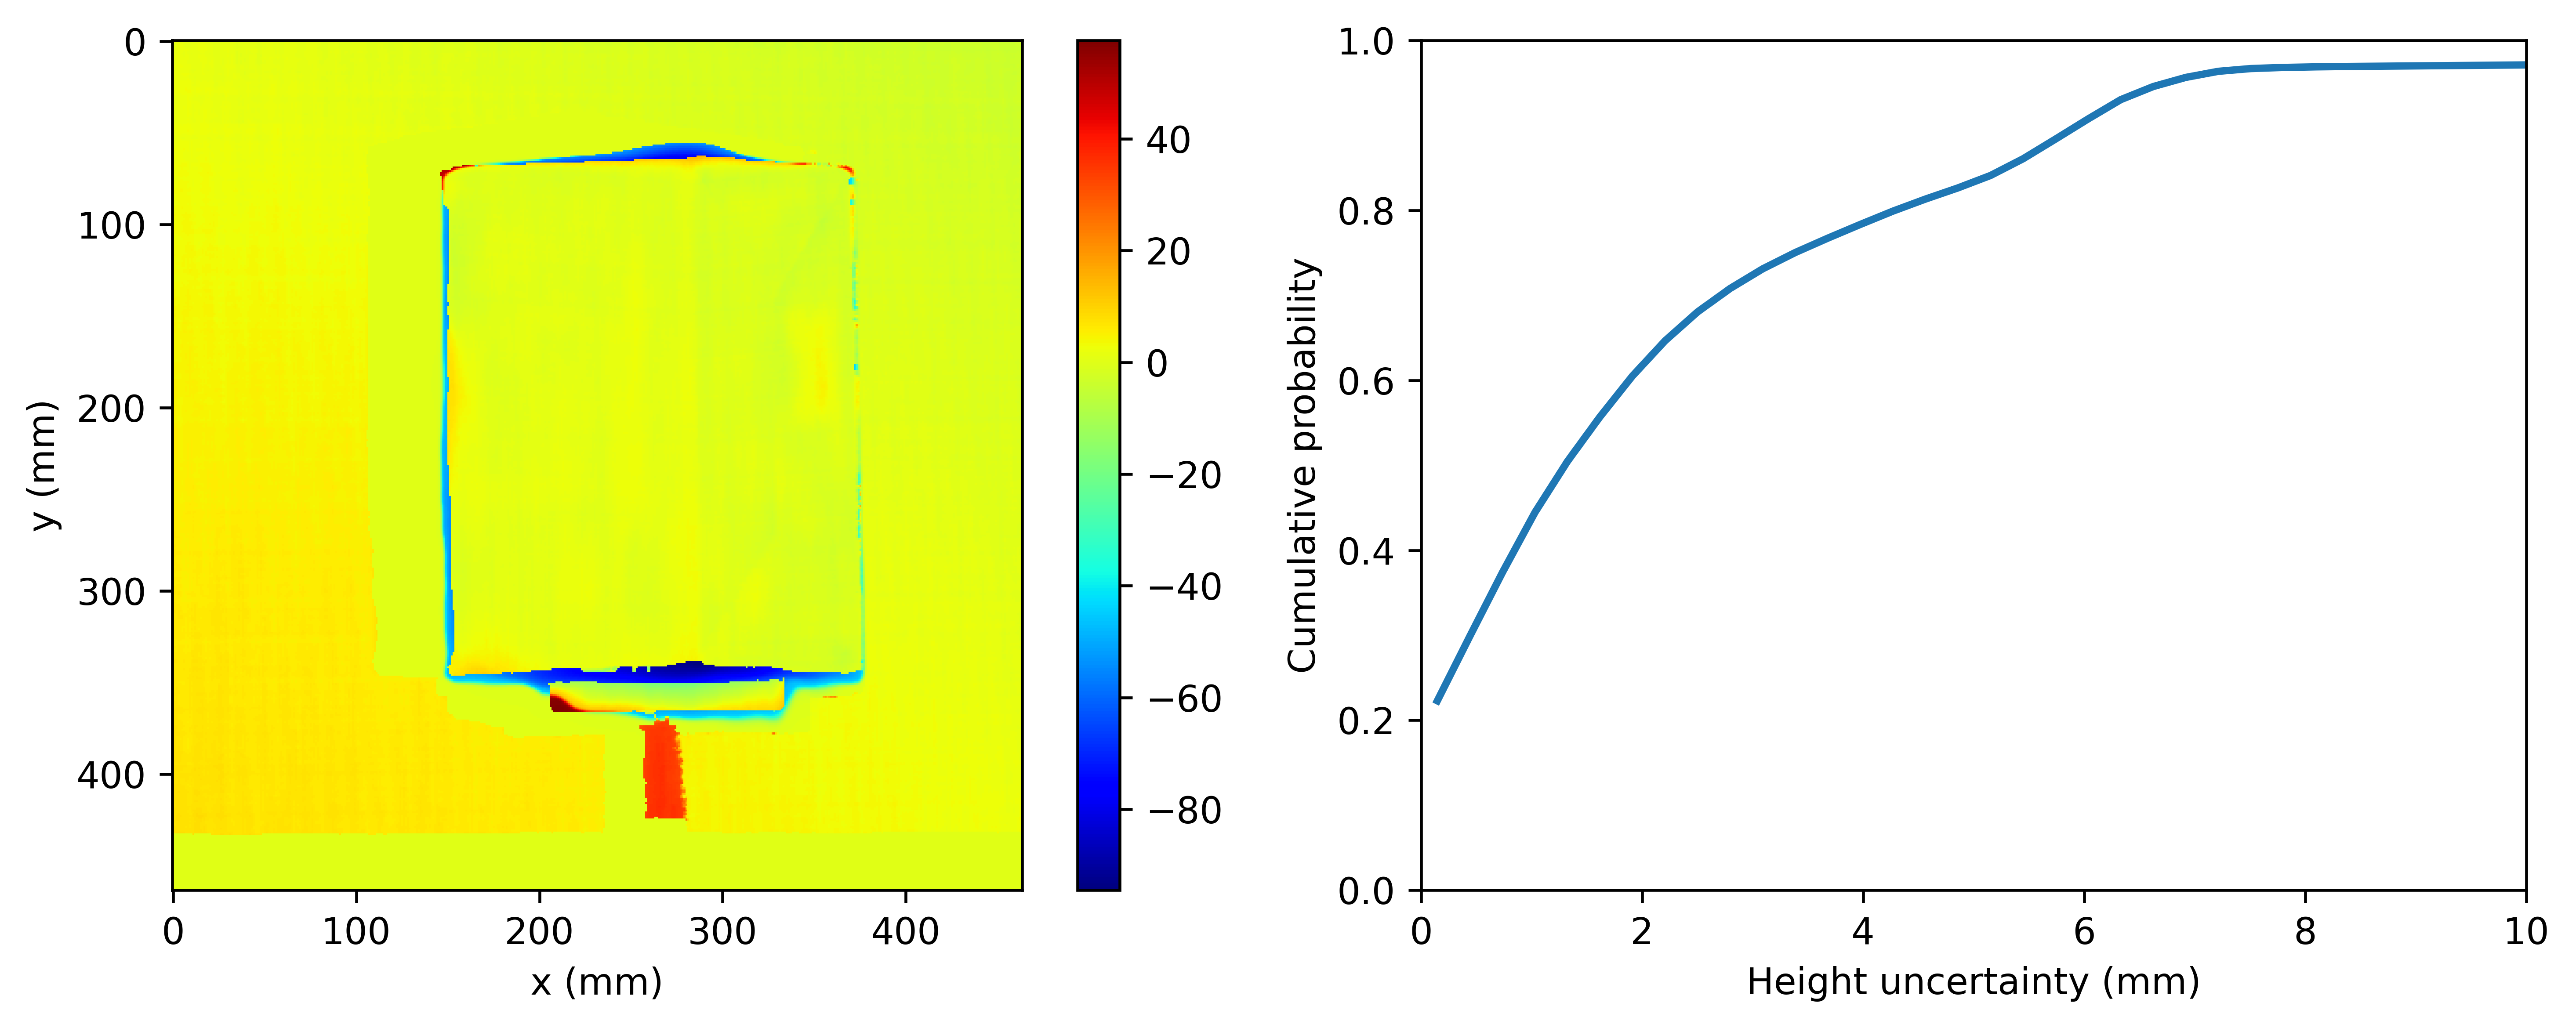

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CDF(error < 4.0 mm) = 77.70%


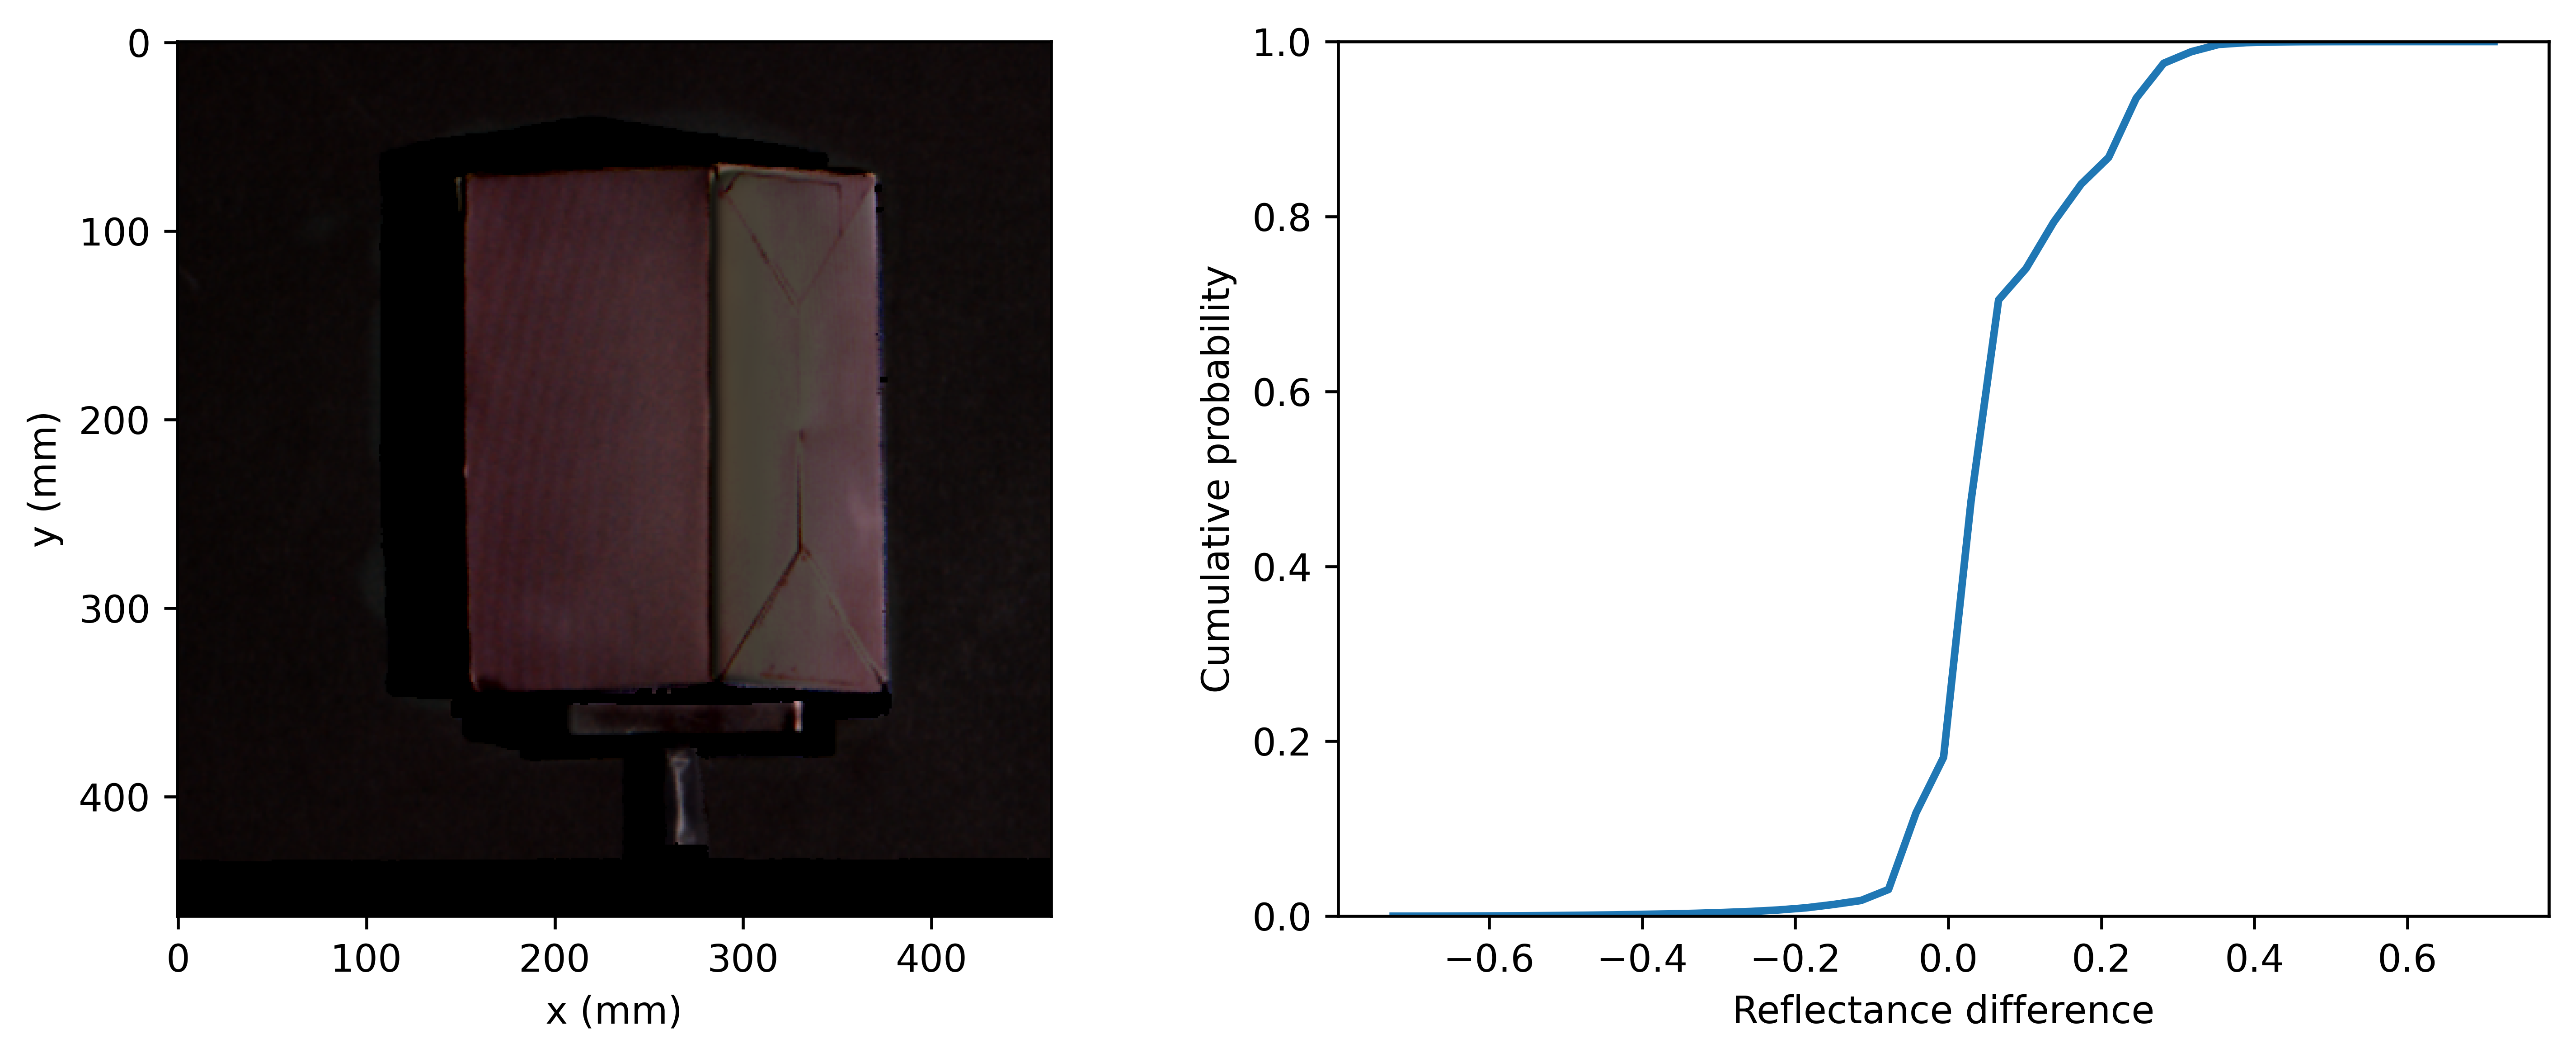

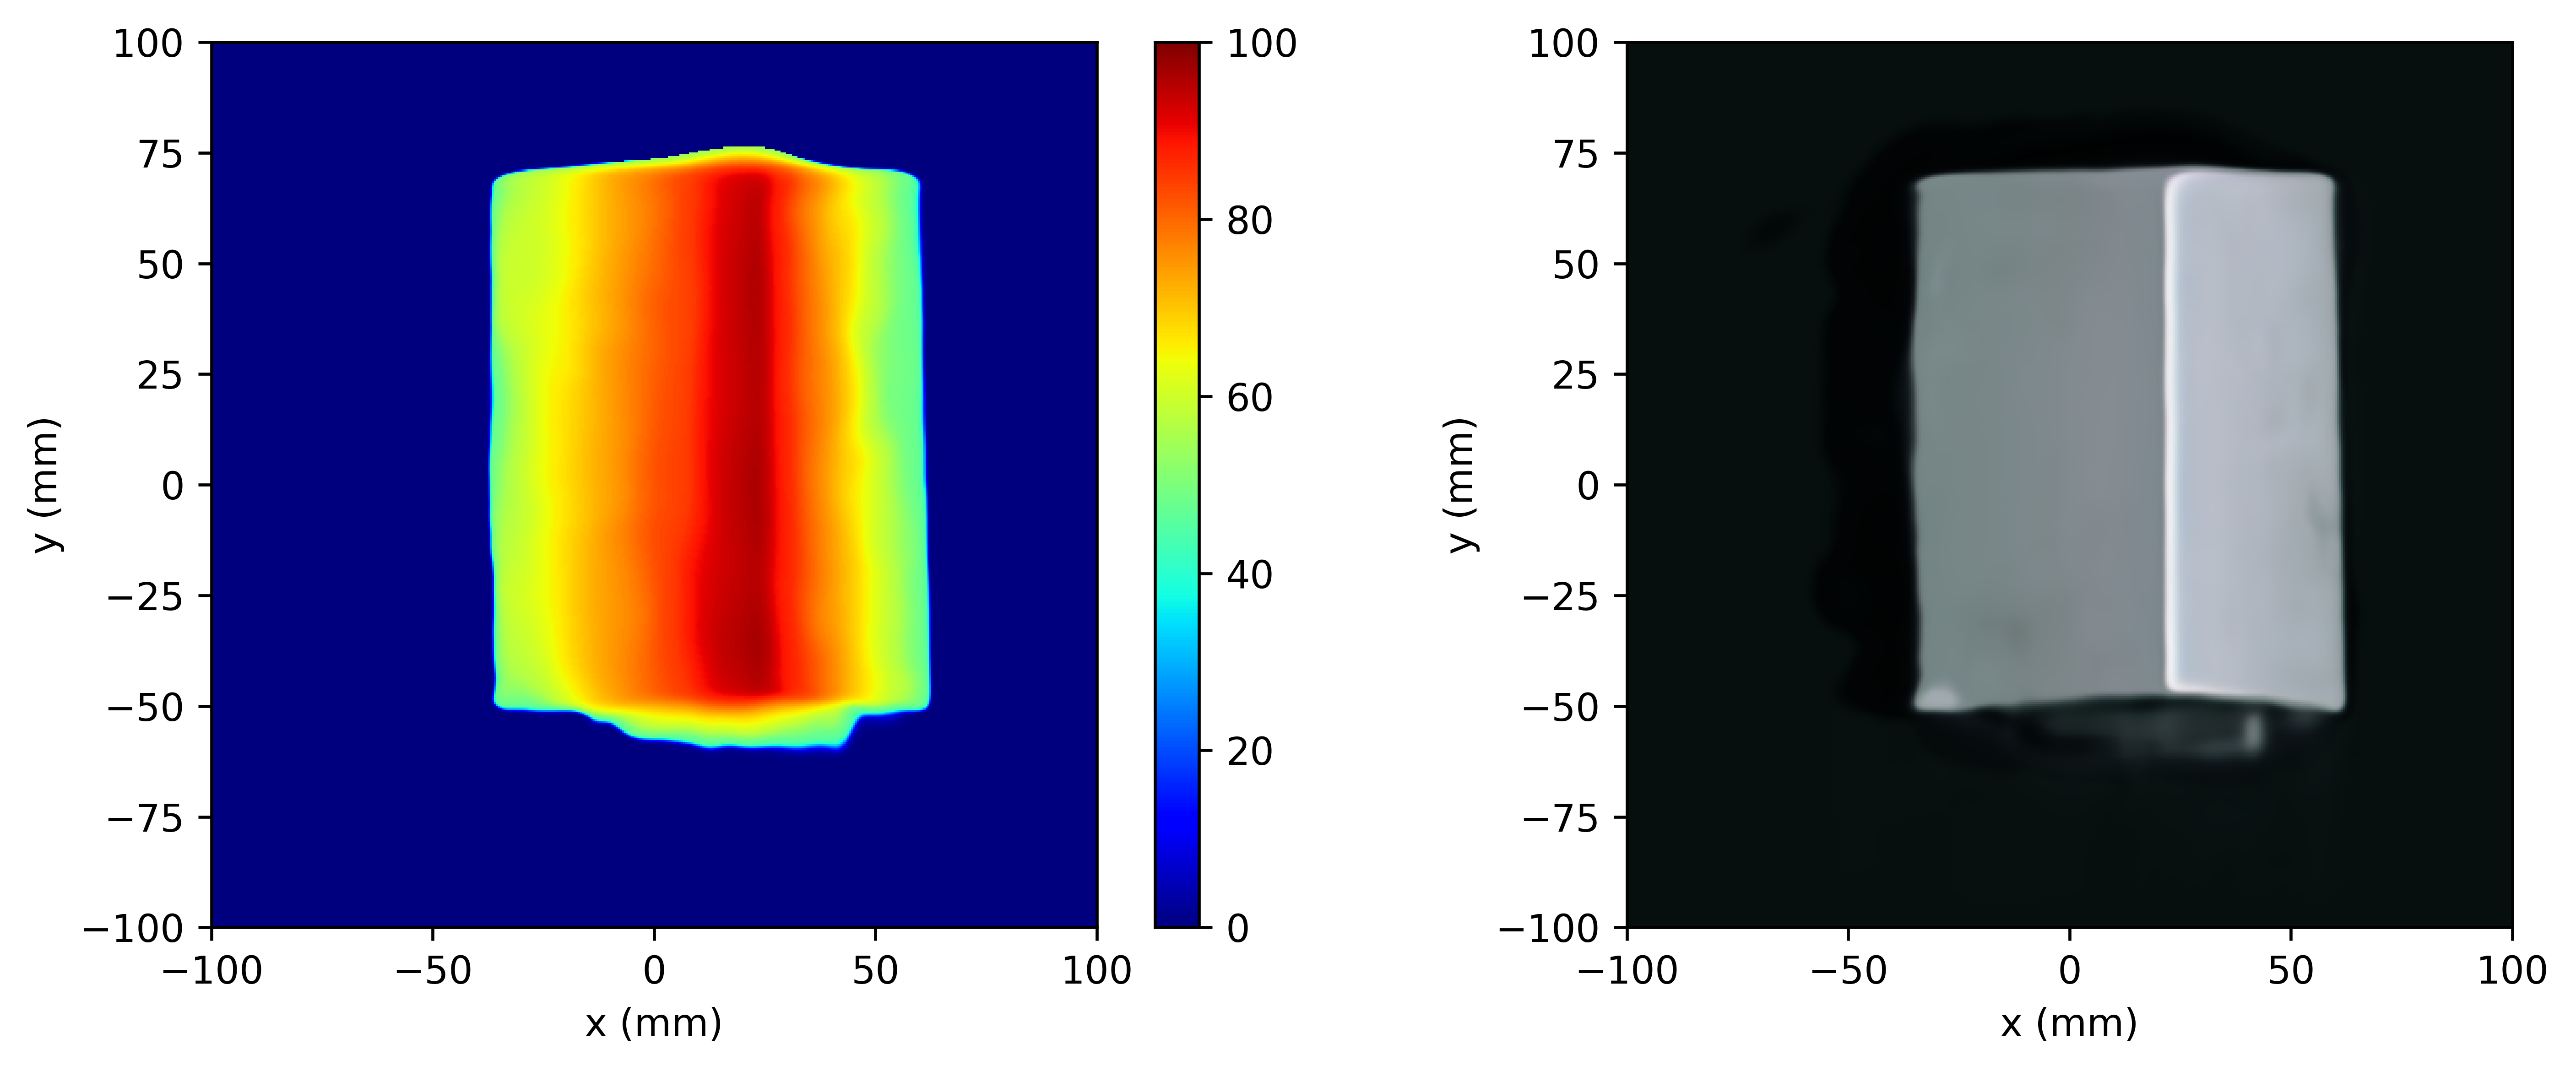

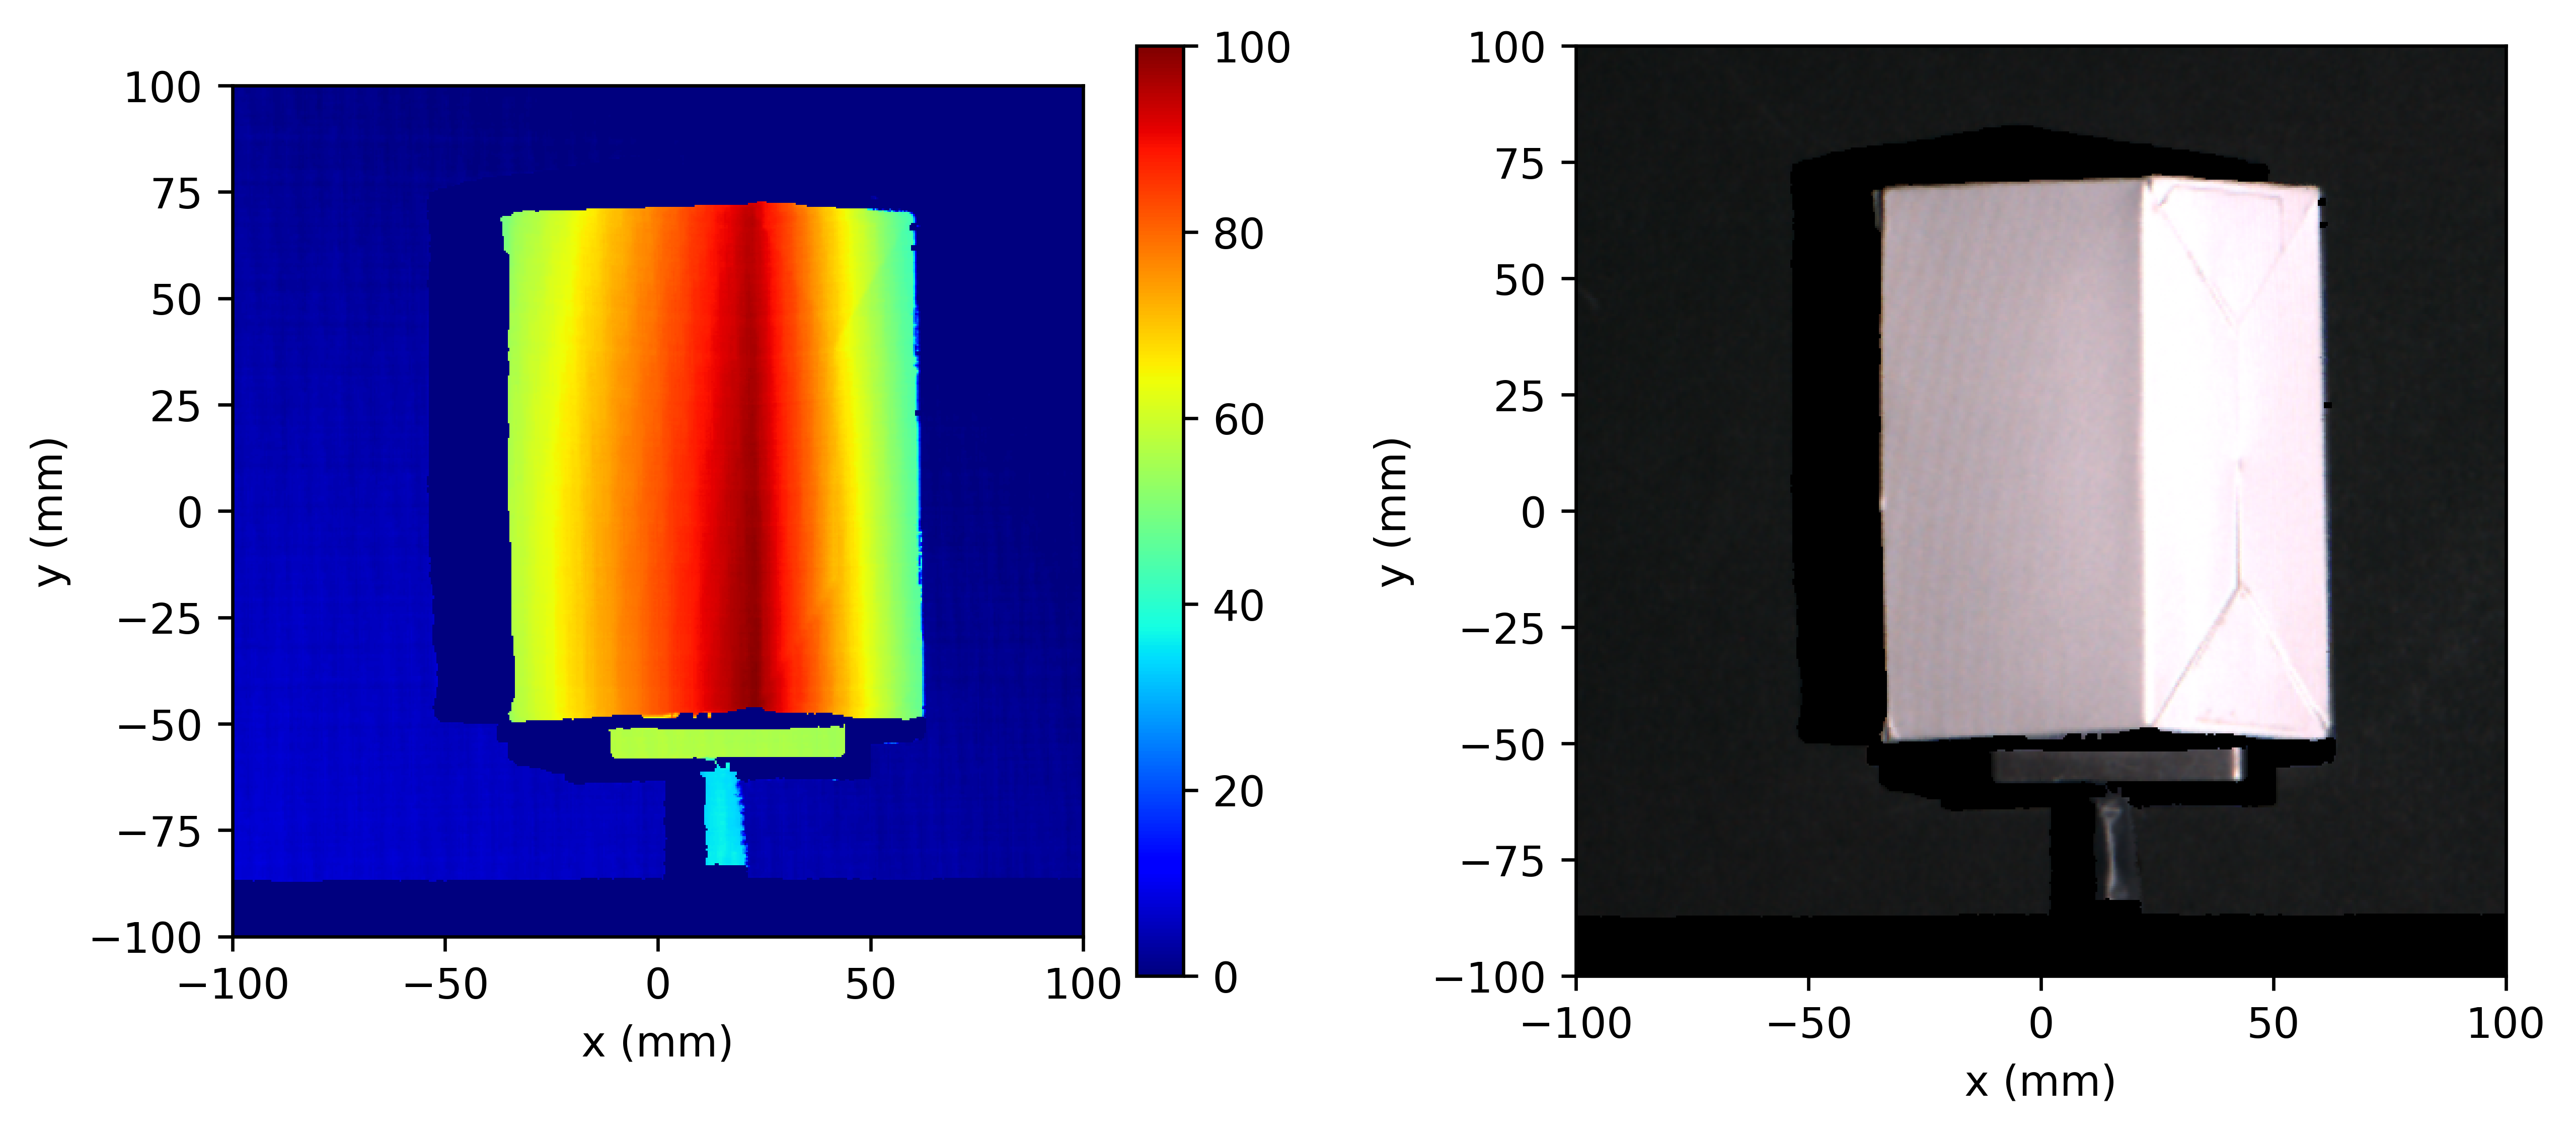

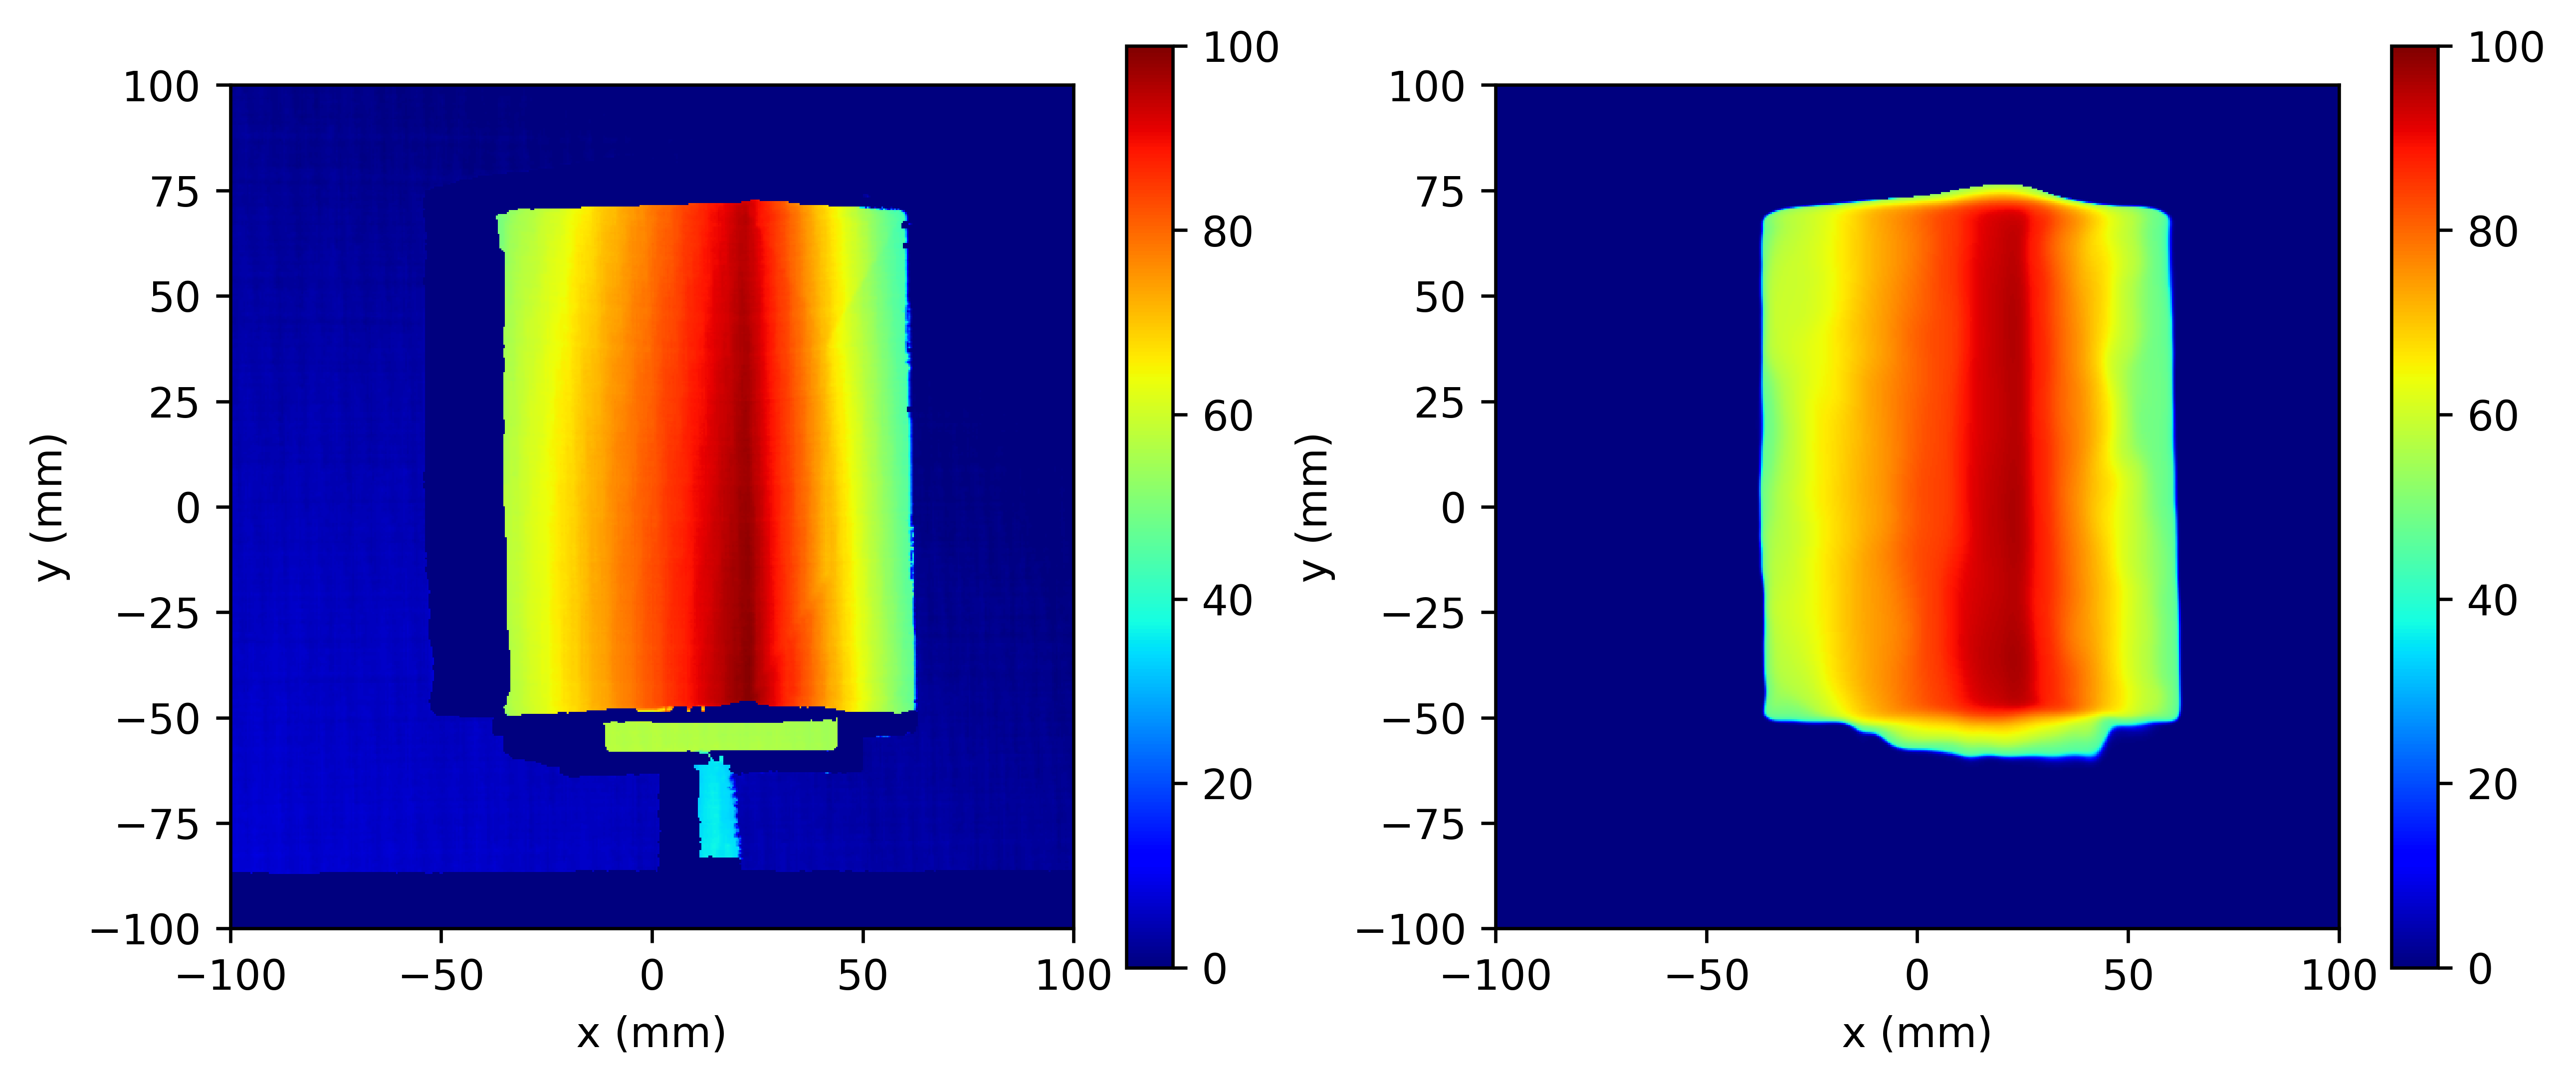

In [3]:
_ = save_and_plot_height_reflectance(
    obj_name='Box',
    data_path='./NN_train_results/Box/',
    ref_path = './Reference_data/Box/',
    img_size=img_size,
    extent=extent,
)


# Cup

0.08800084740130192


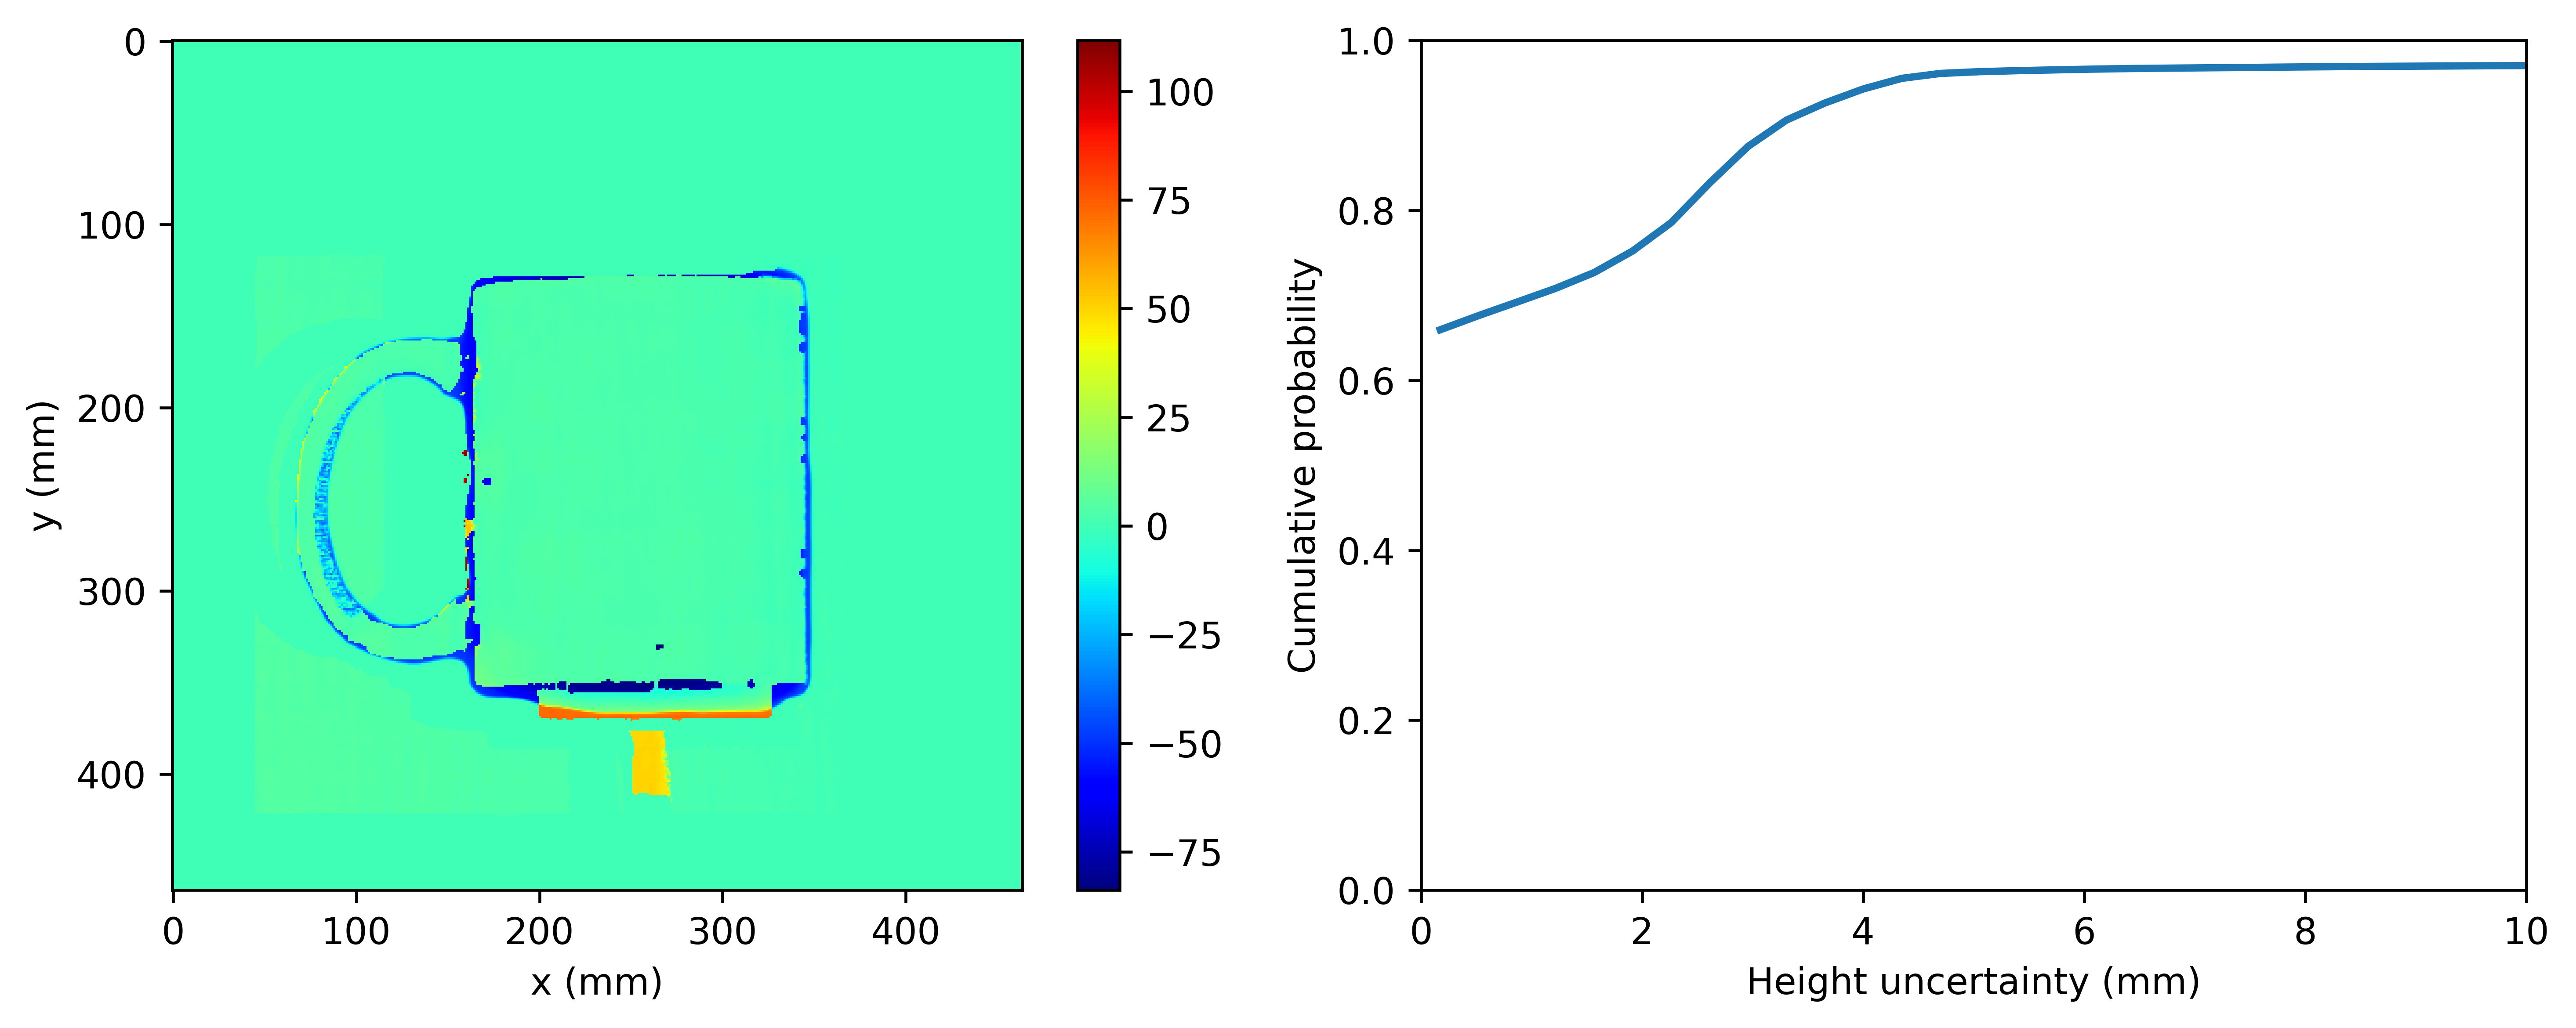

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CDF(error < 4.0 mm) = 93.52%


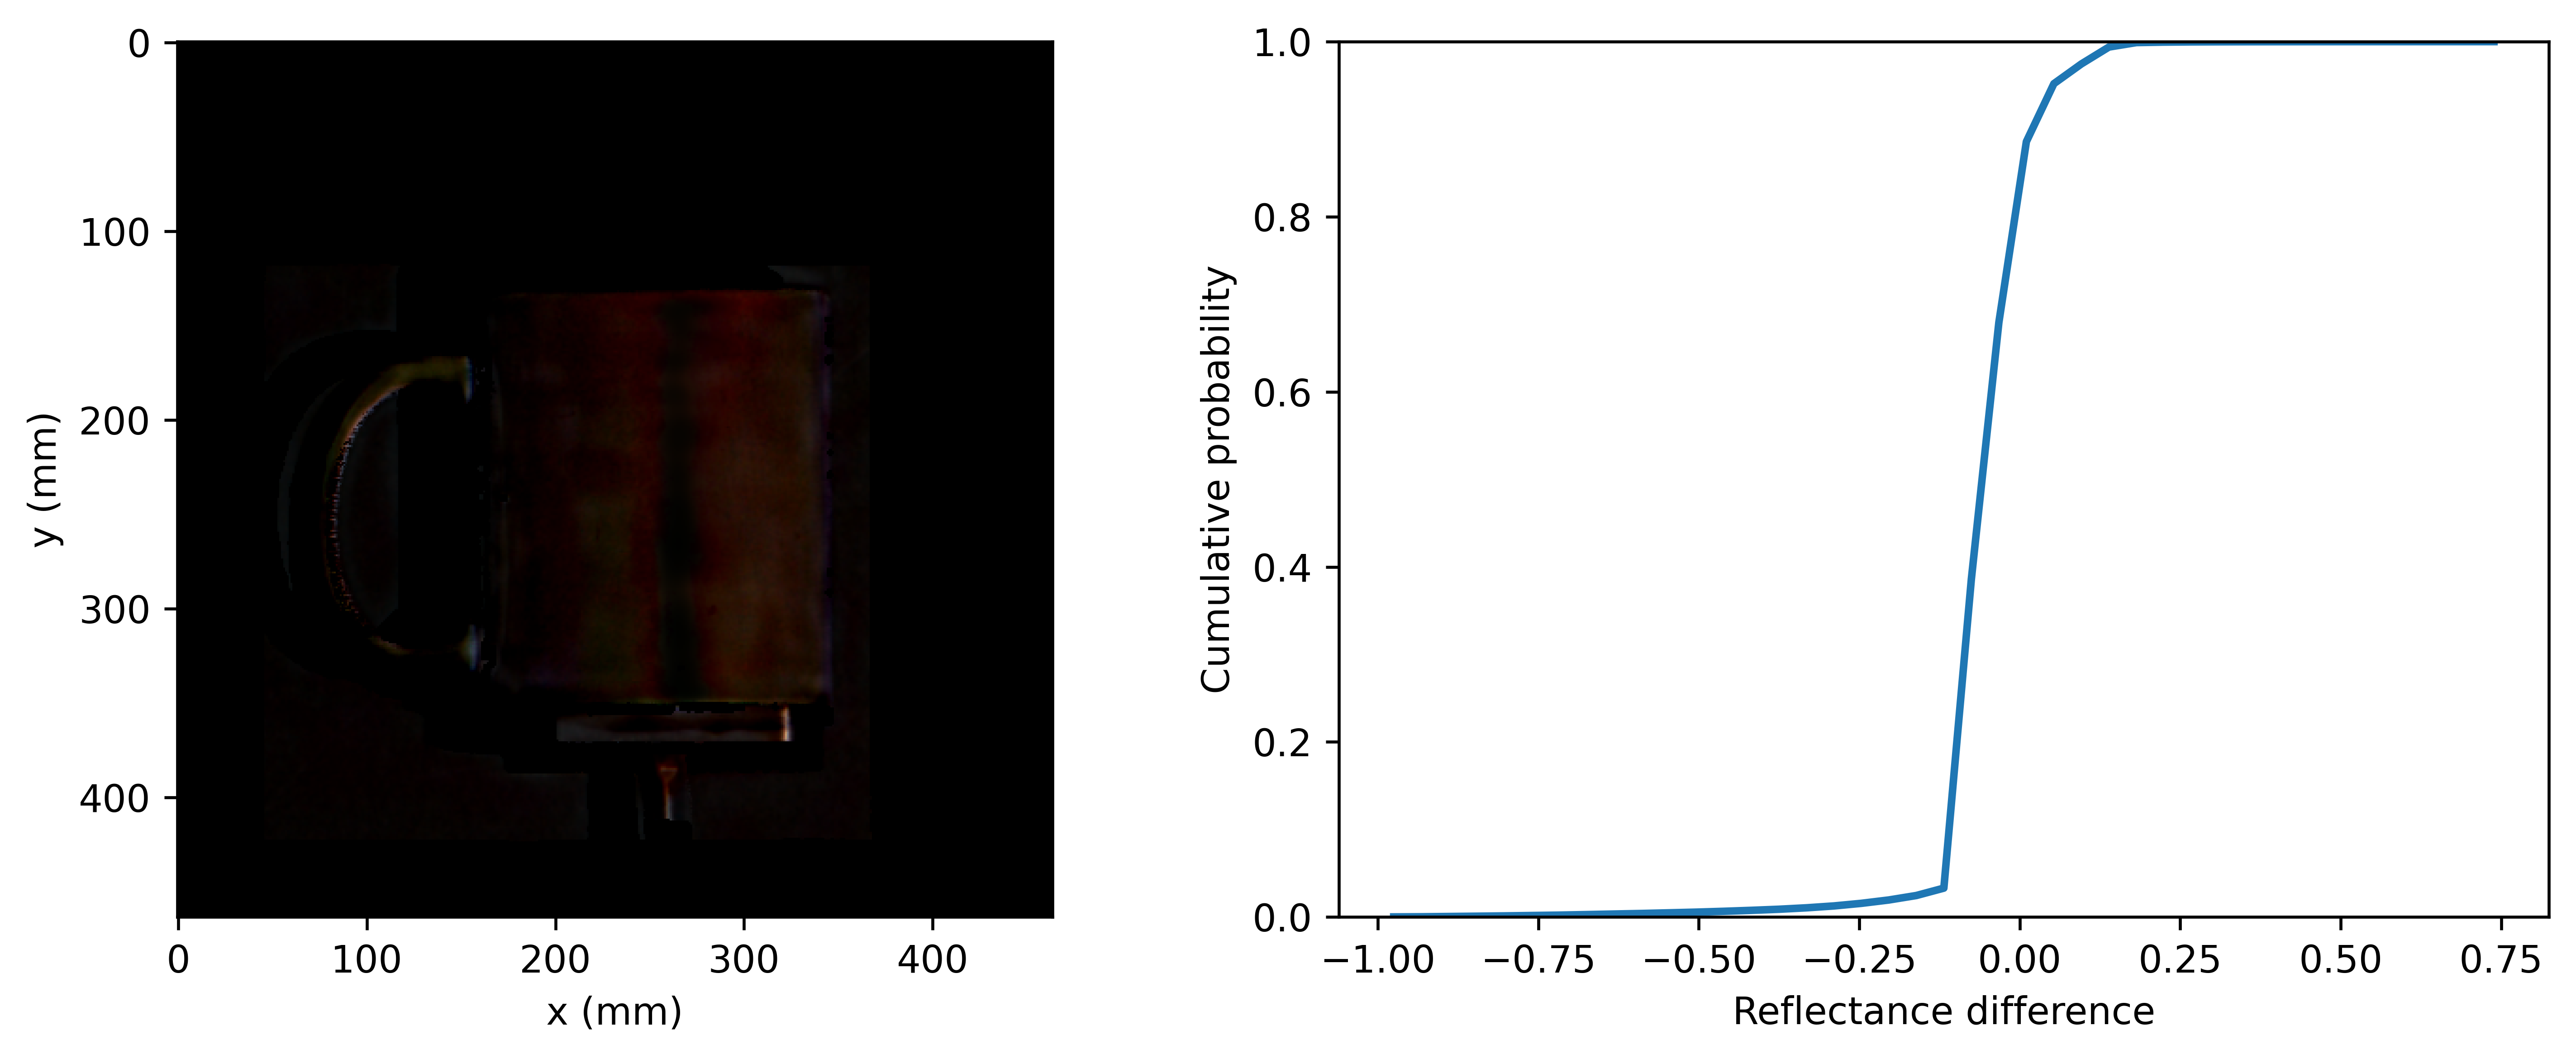

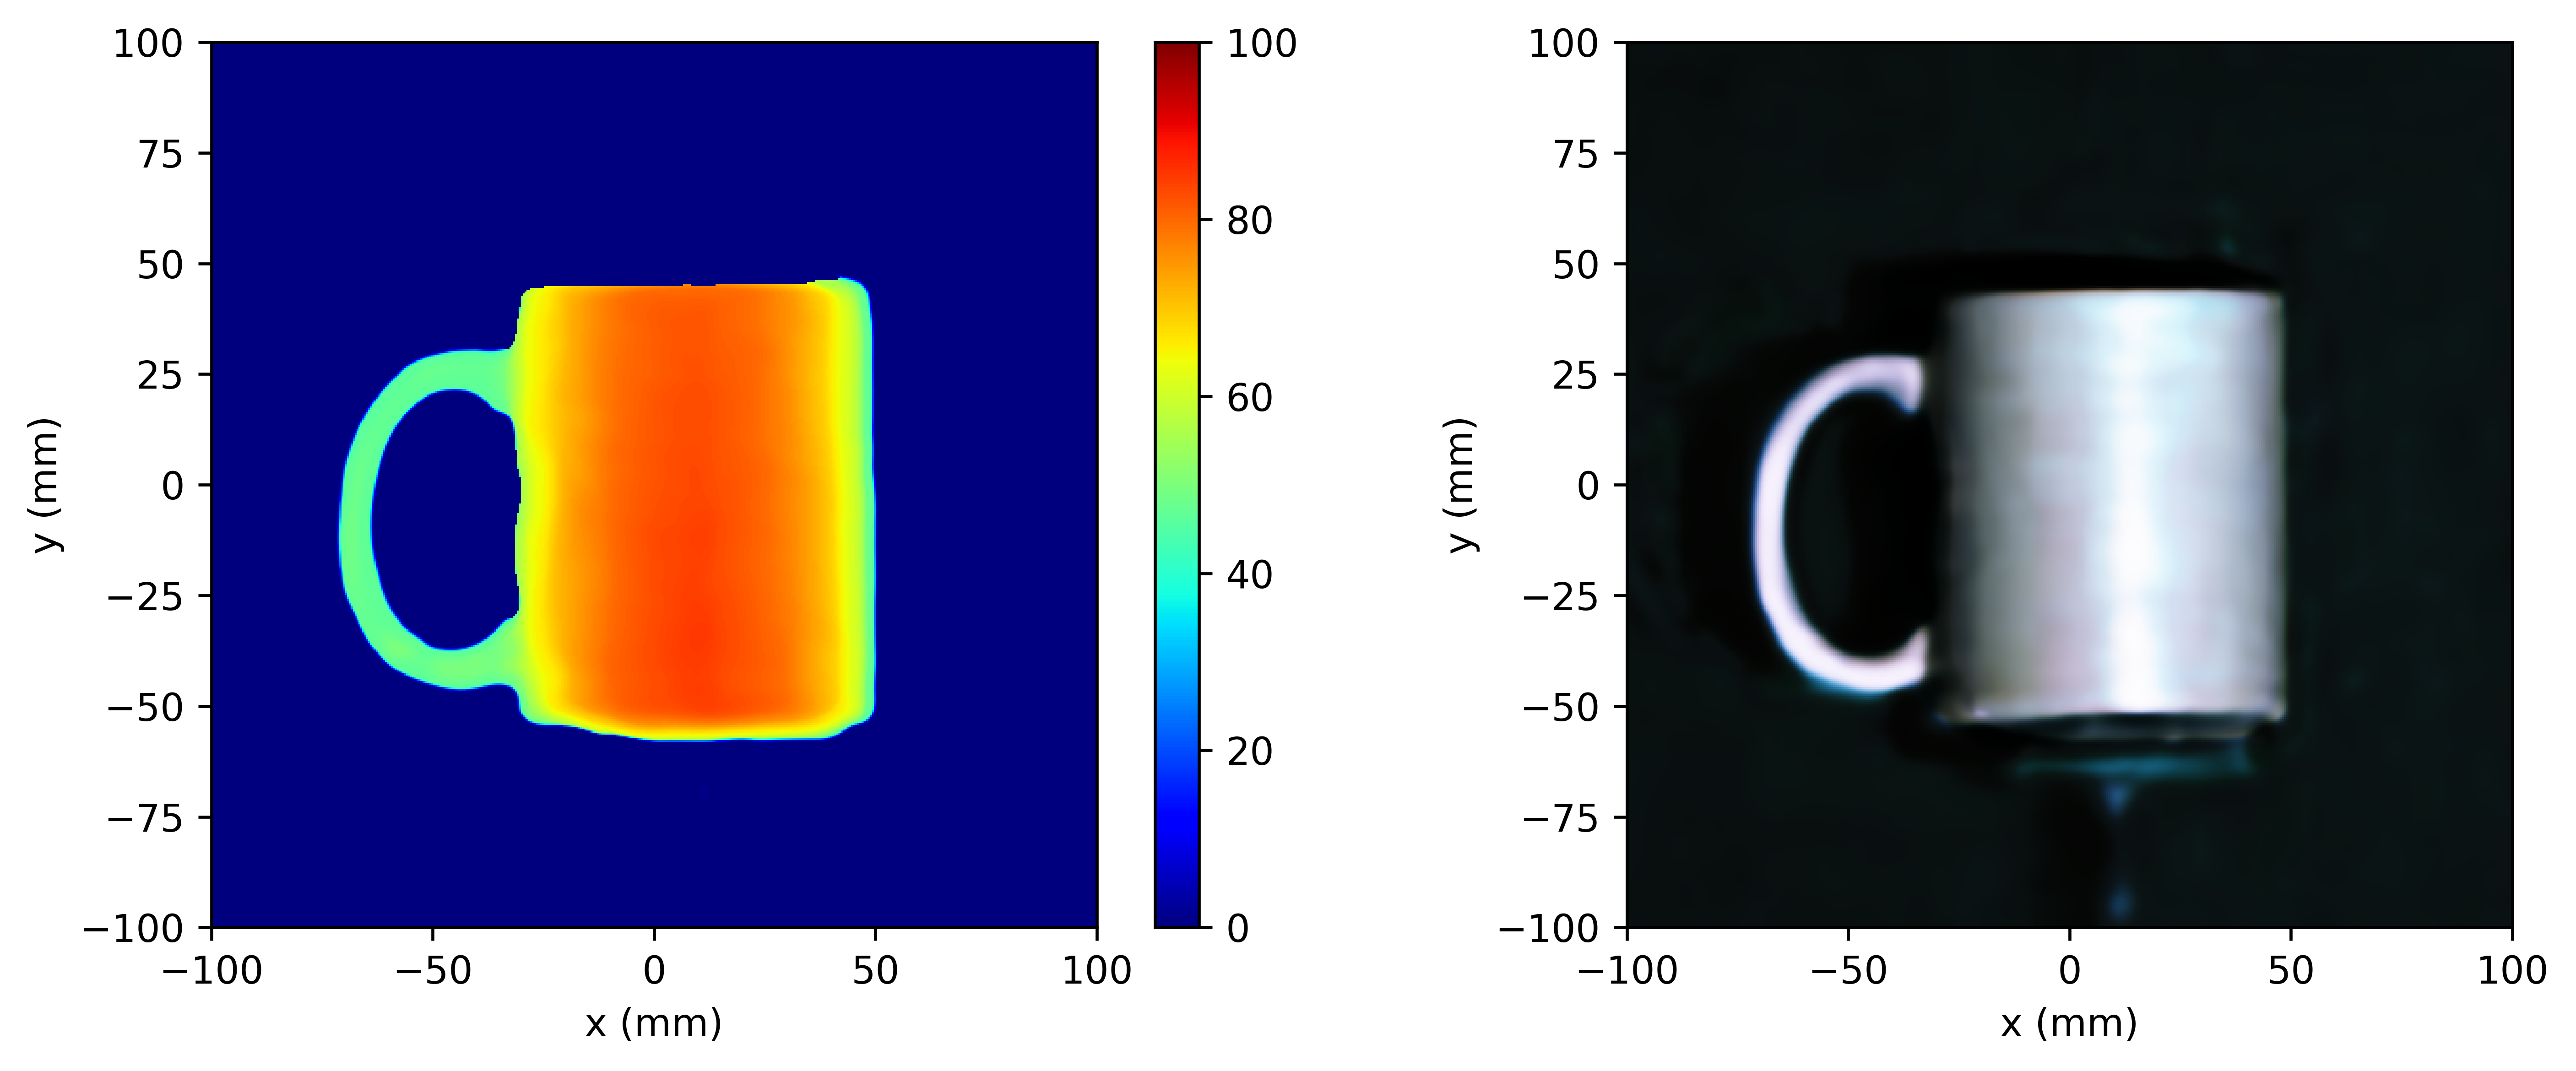

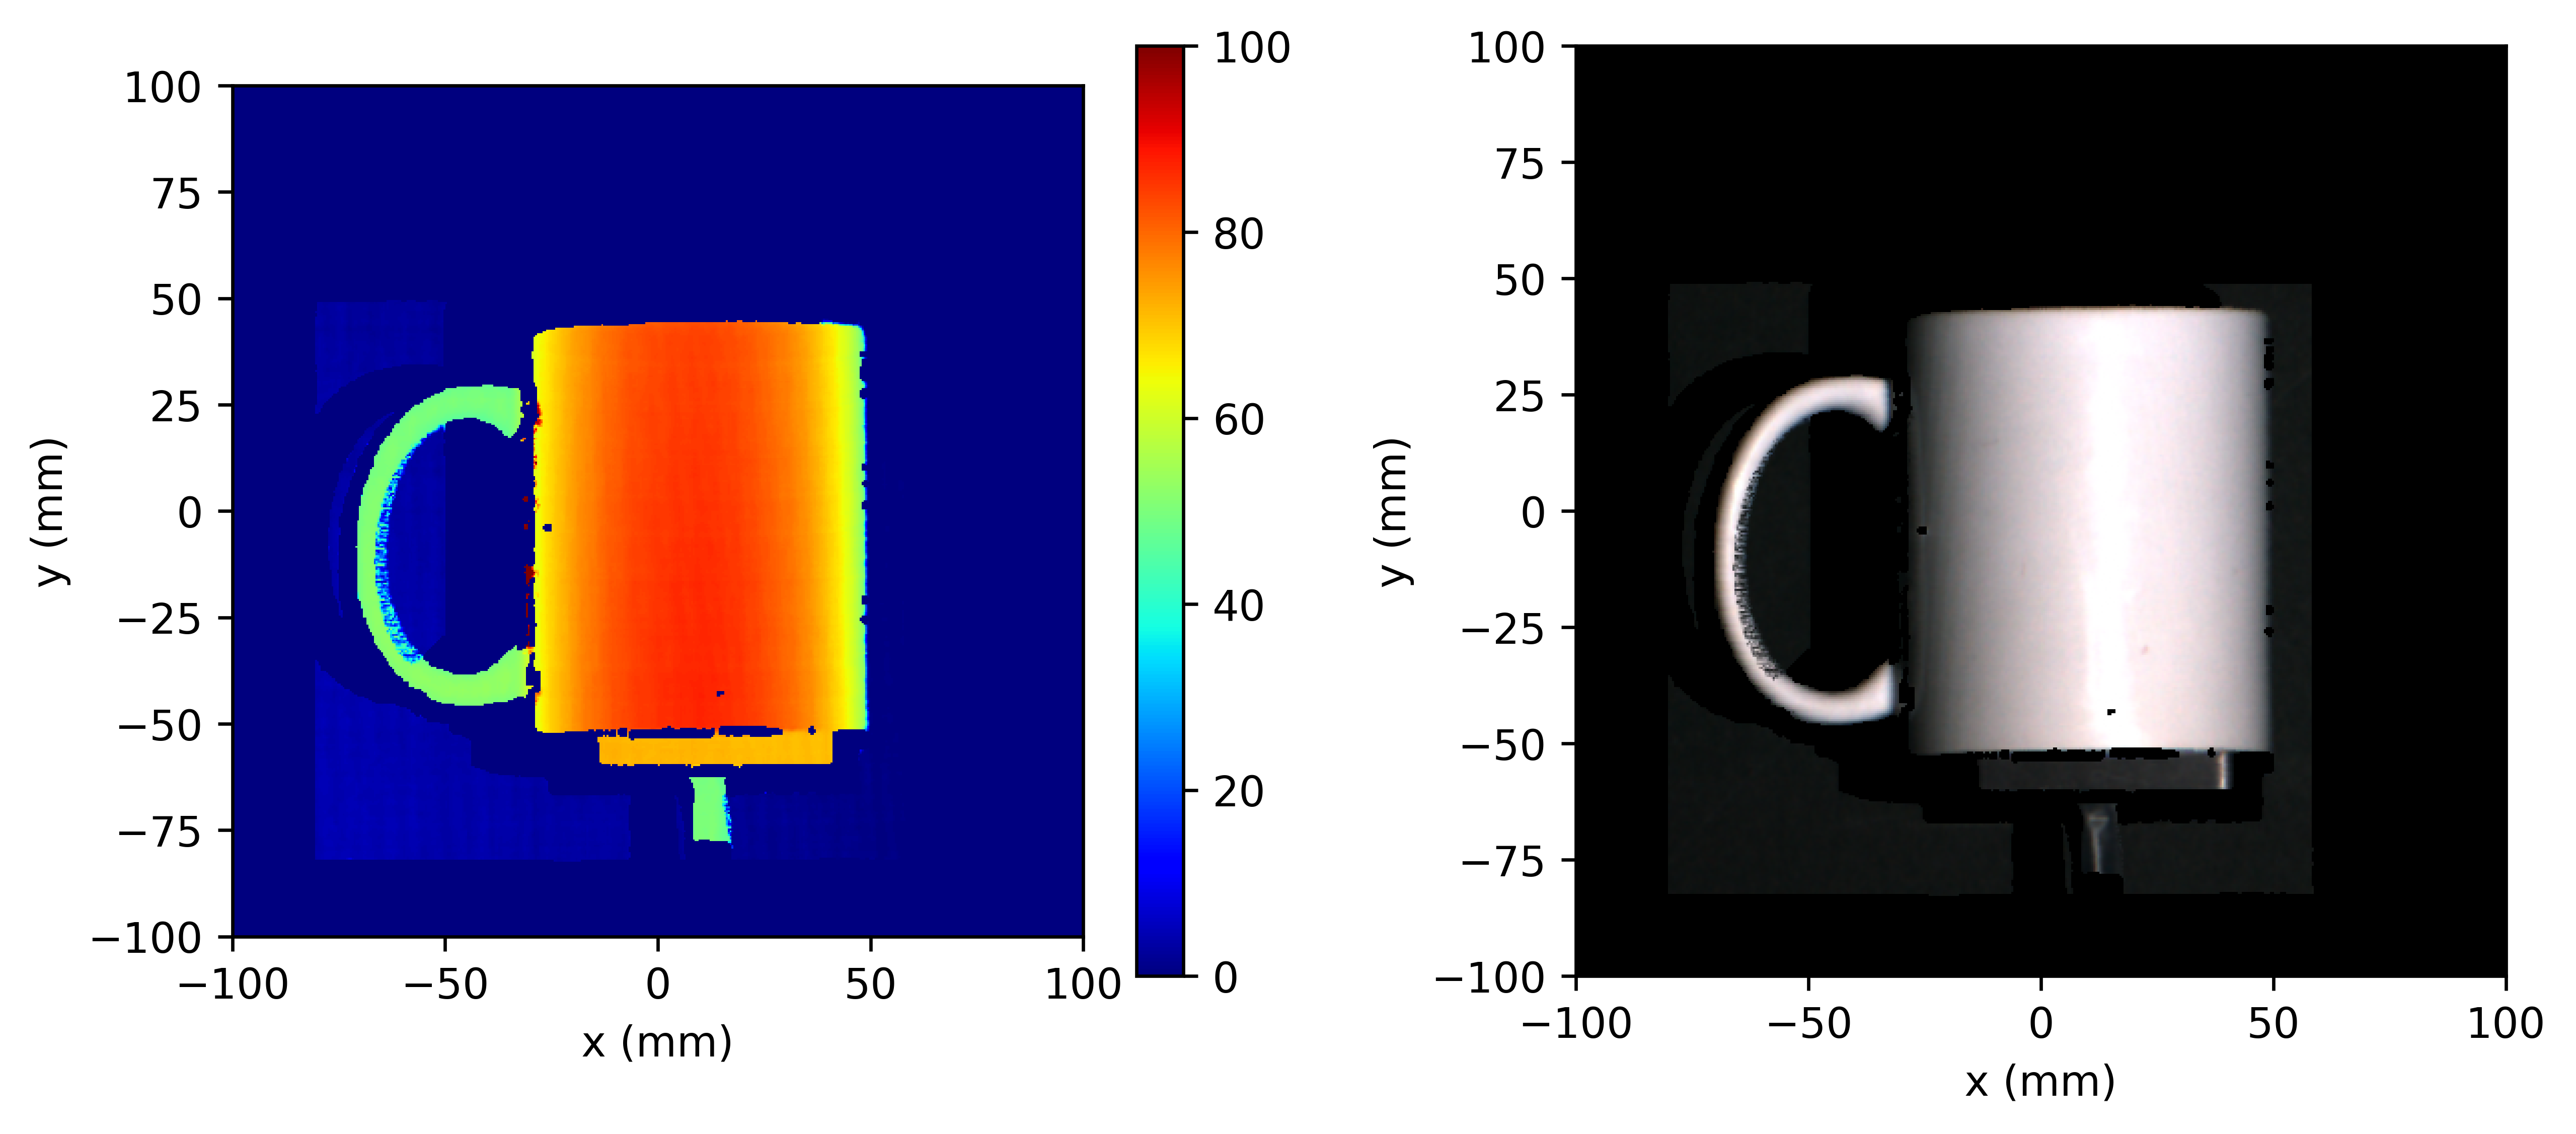

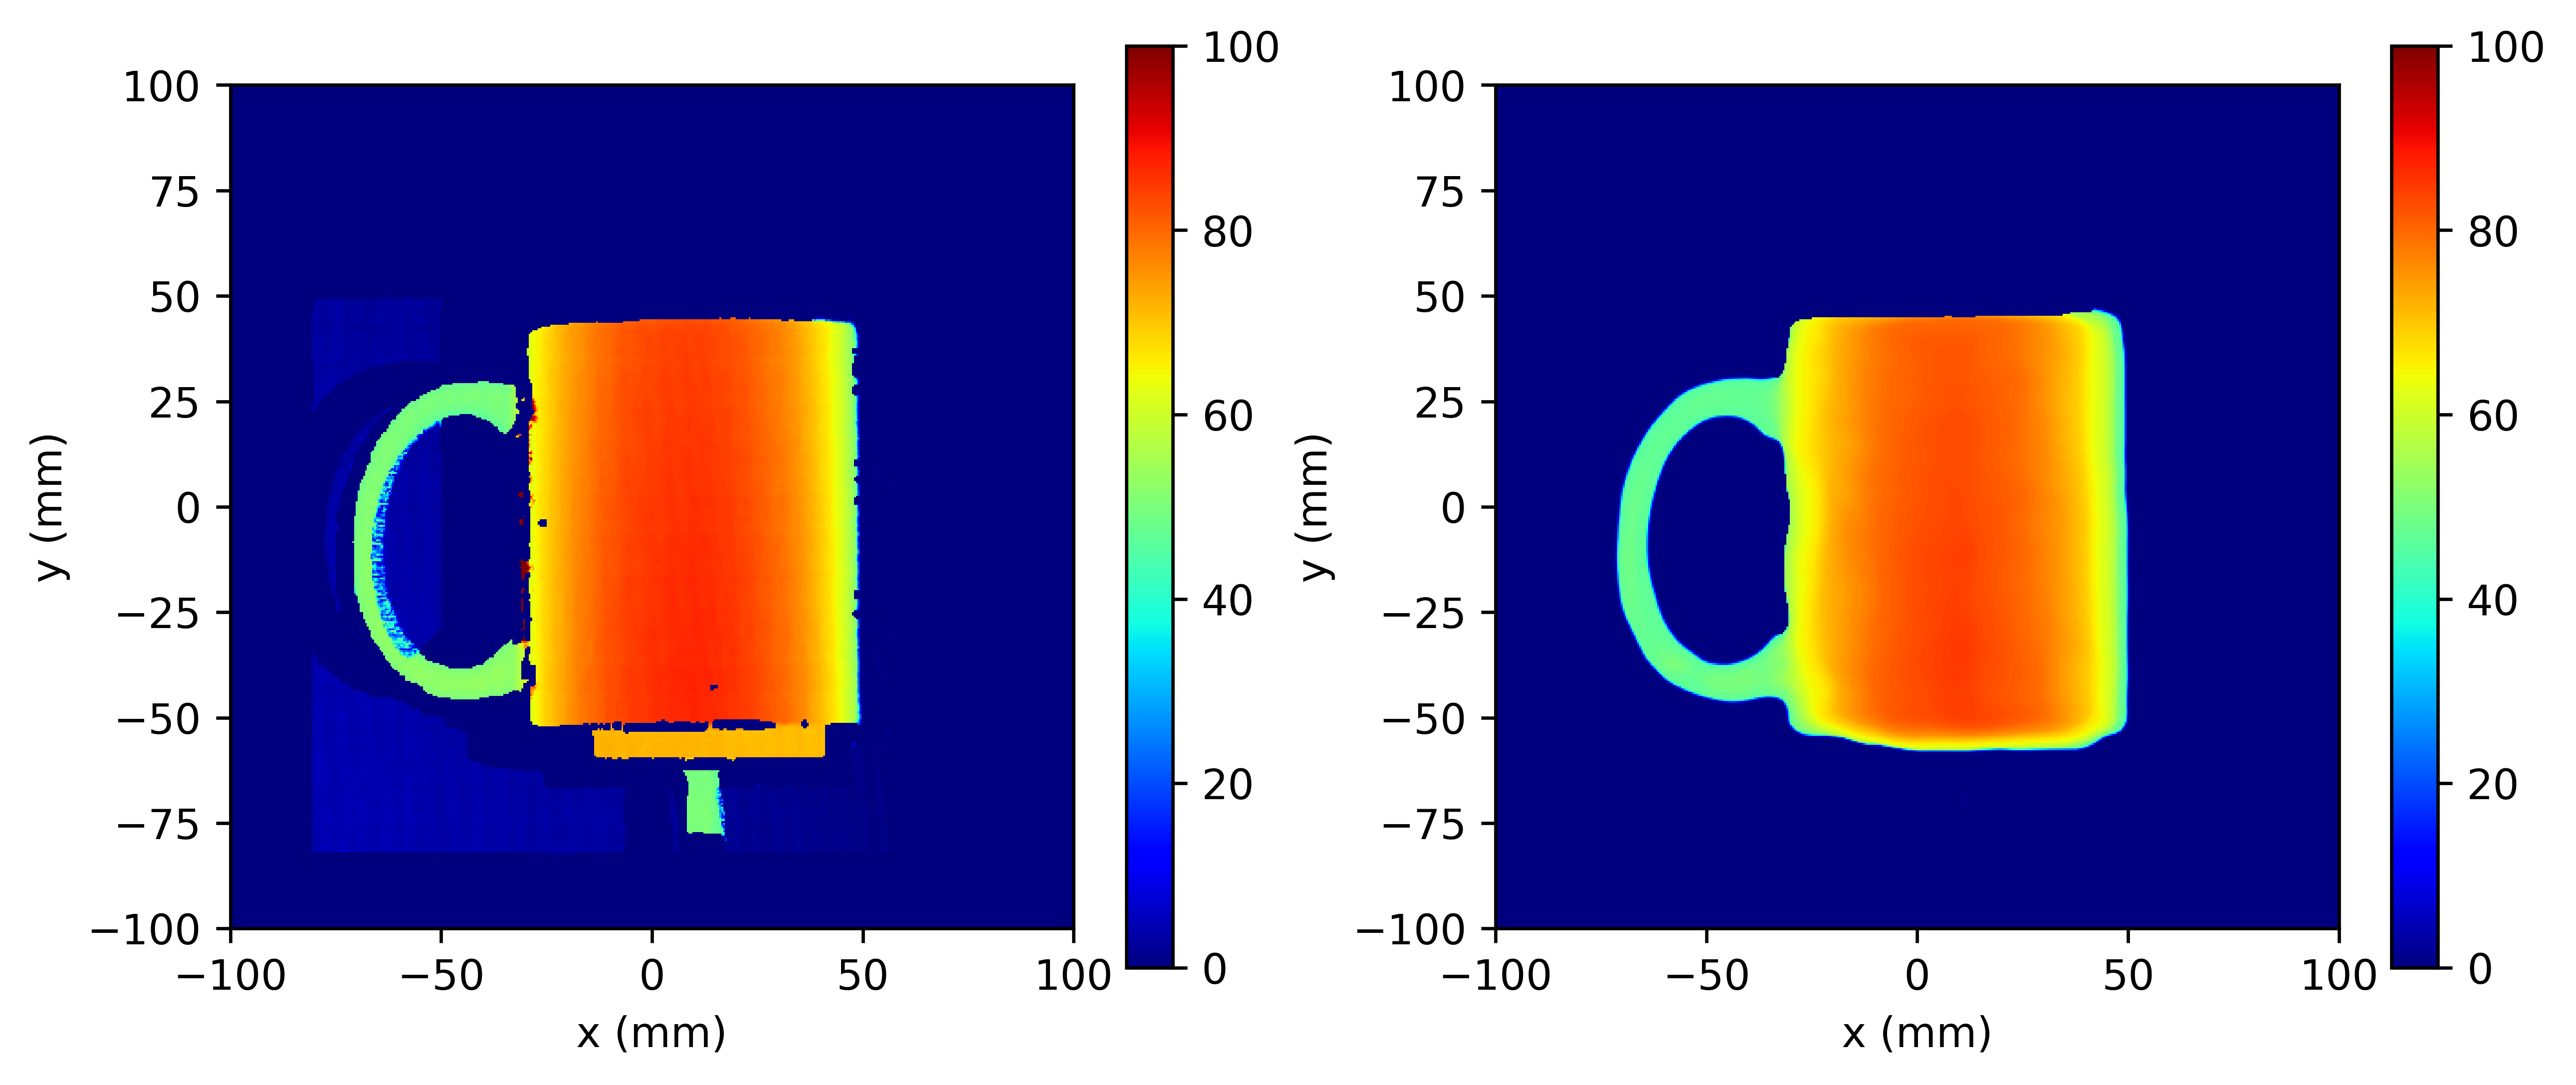

In [4]:

_ = save_and_plot_height_reflectance(
    obj_name='Cup',
    data_path='./NN_train_results/Cup/',
    ref_path = './Reference_data/Cup/',
    img_size=img_size,
    extent=extent,
)


# Buzz

0.4990984496106355


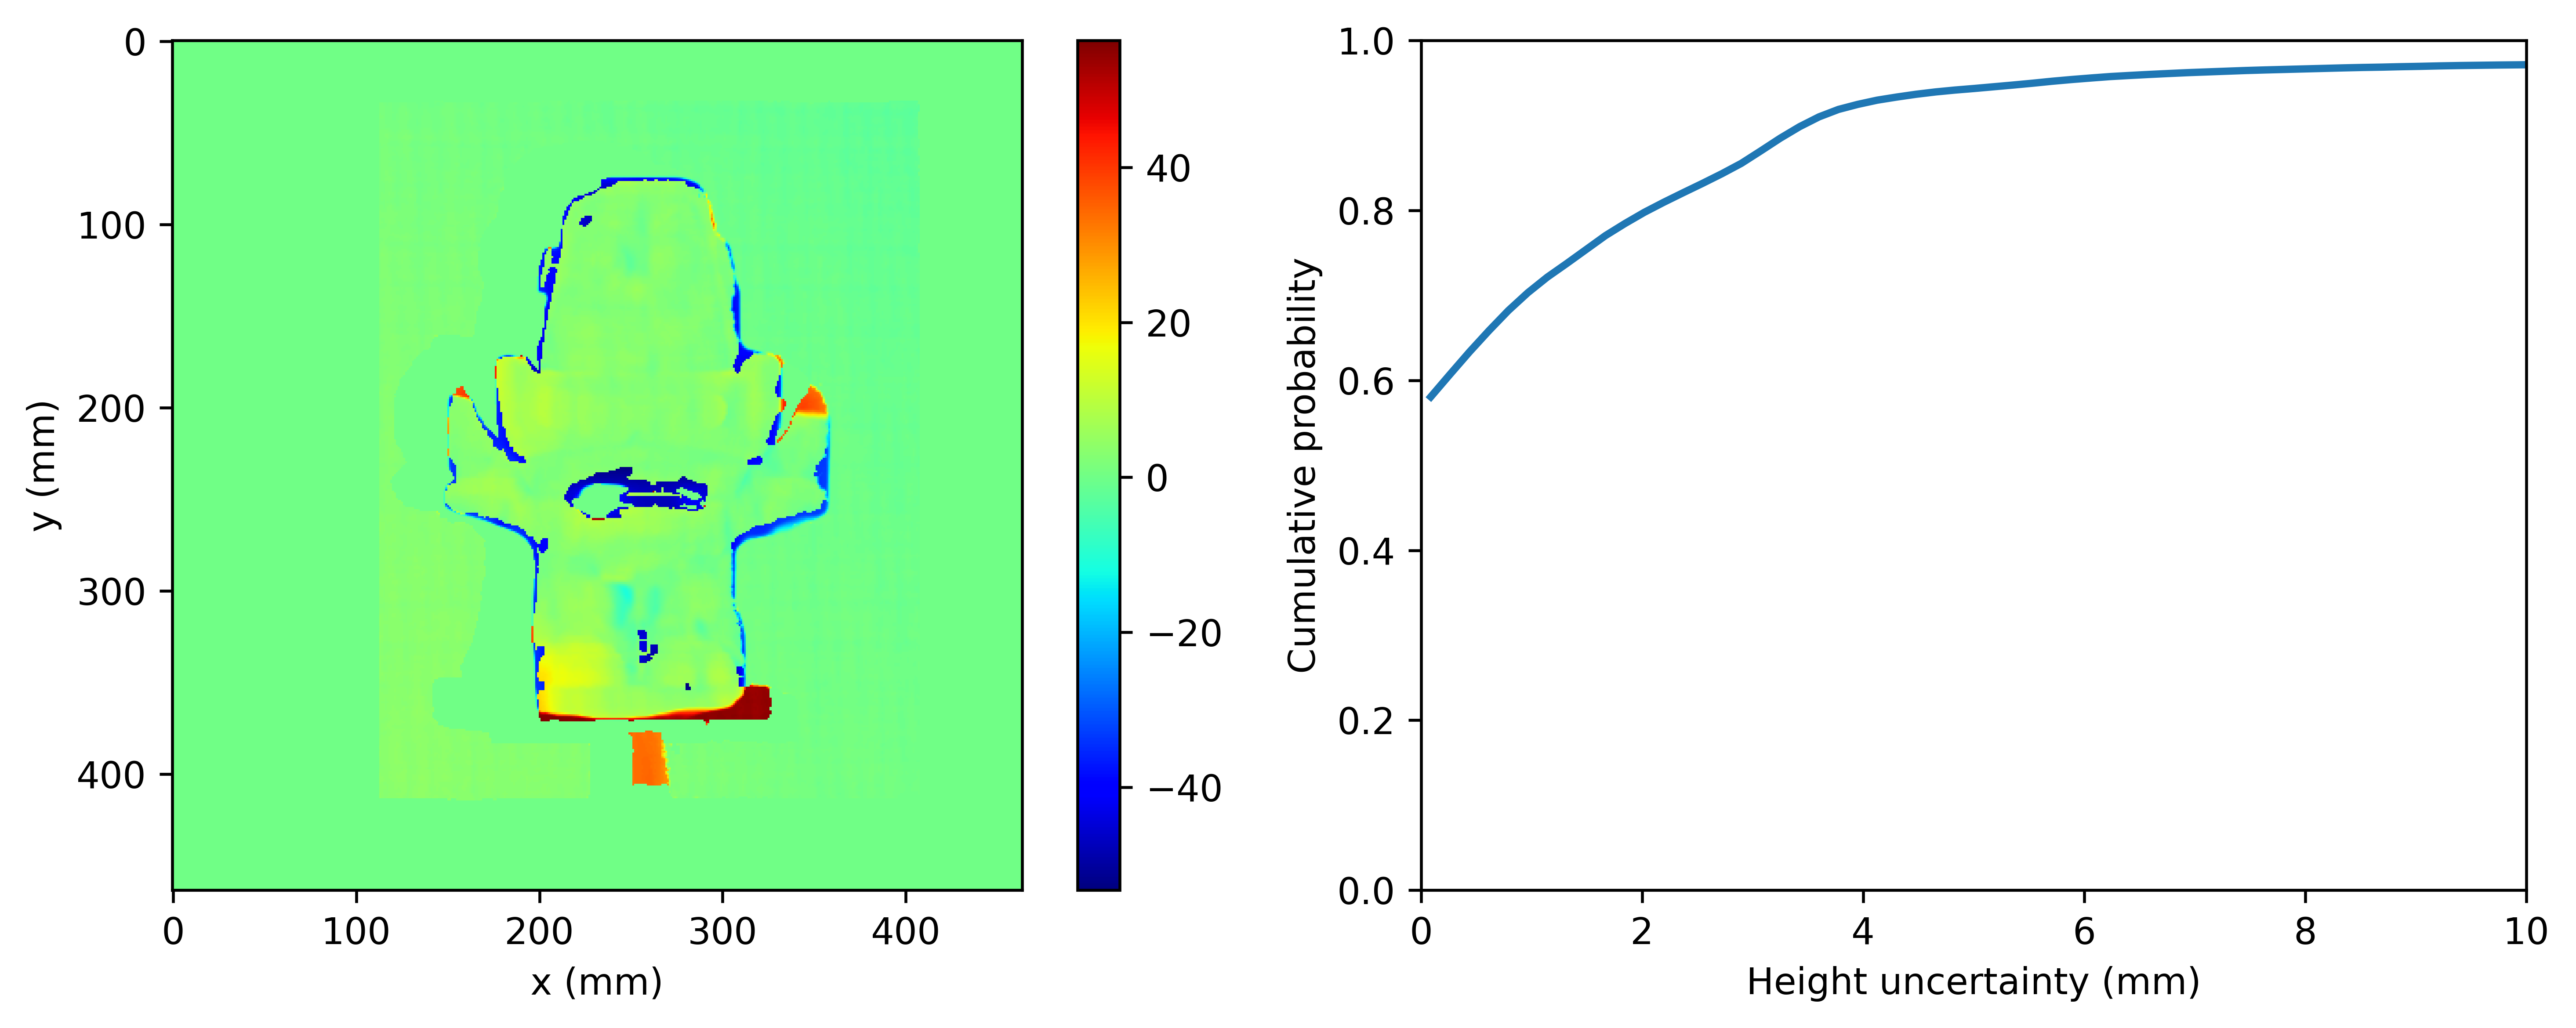

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CDF(error < 4.0 mm) = 92.36%


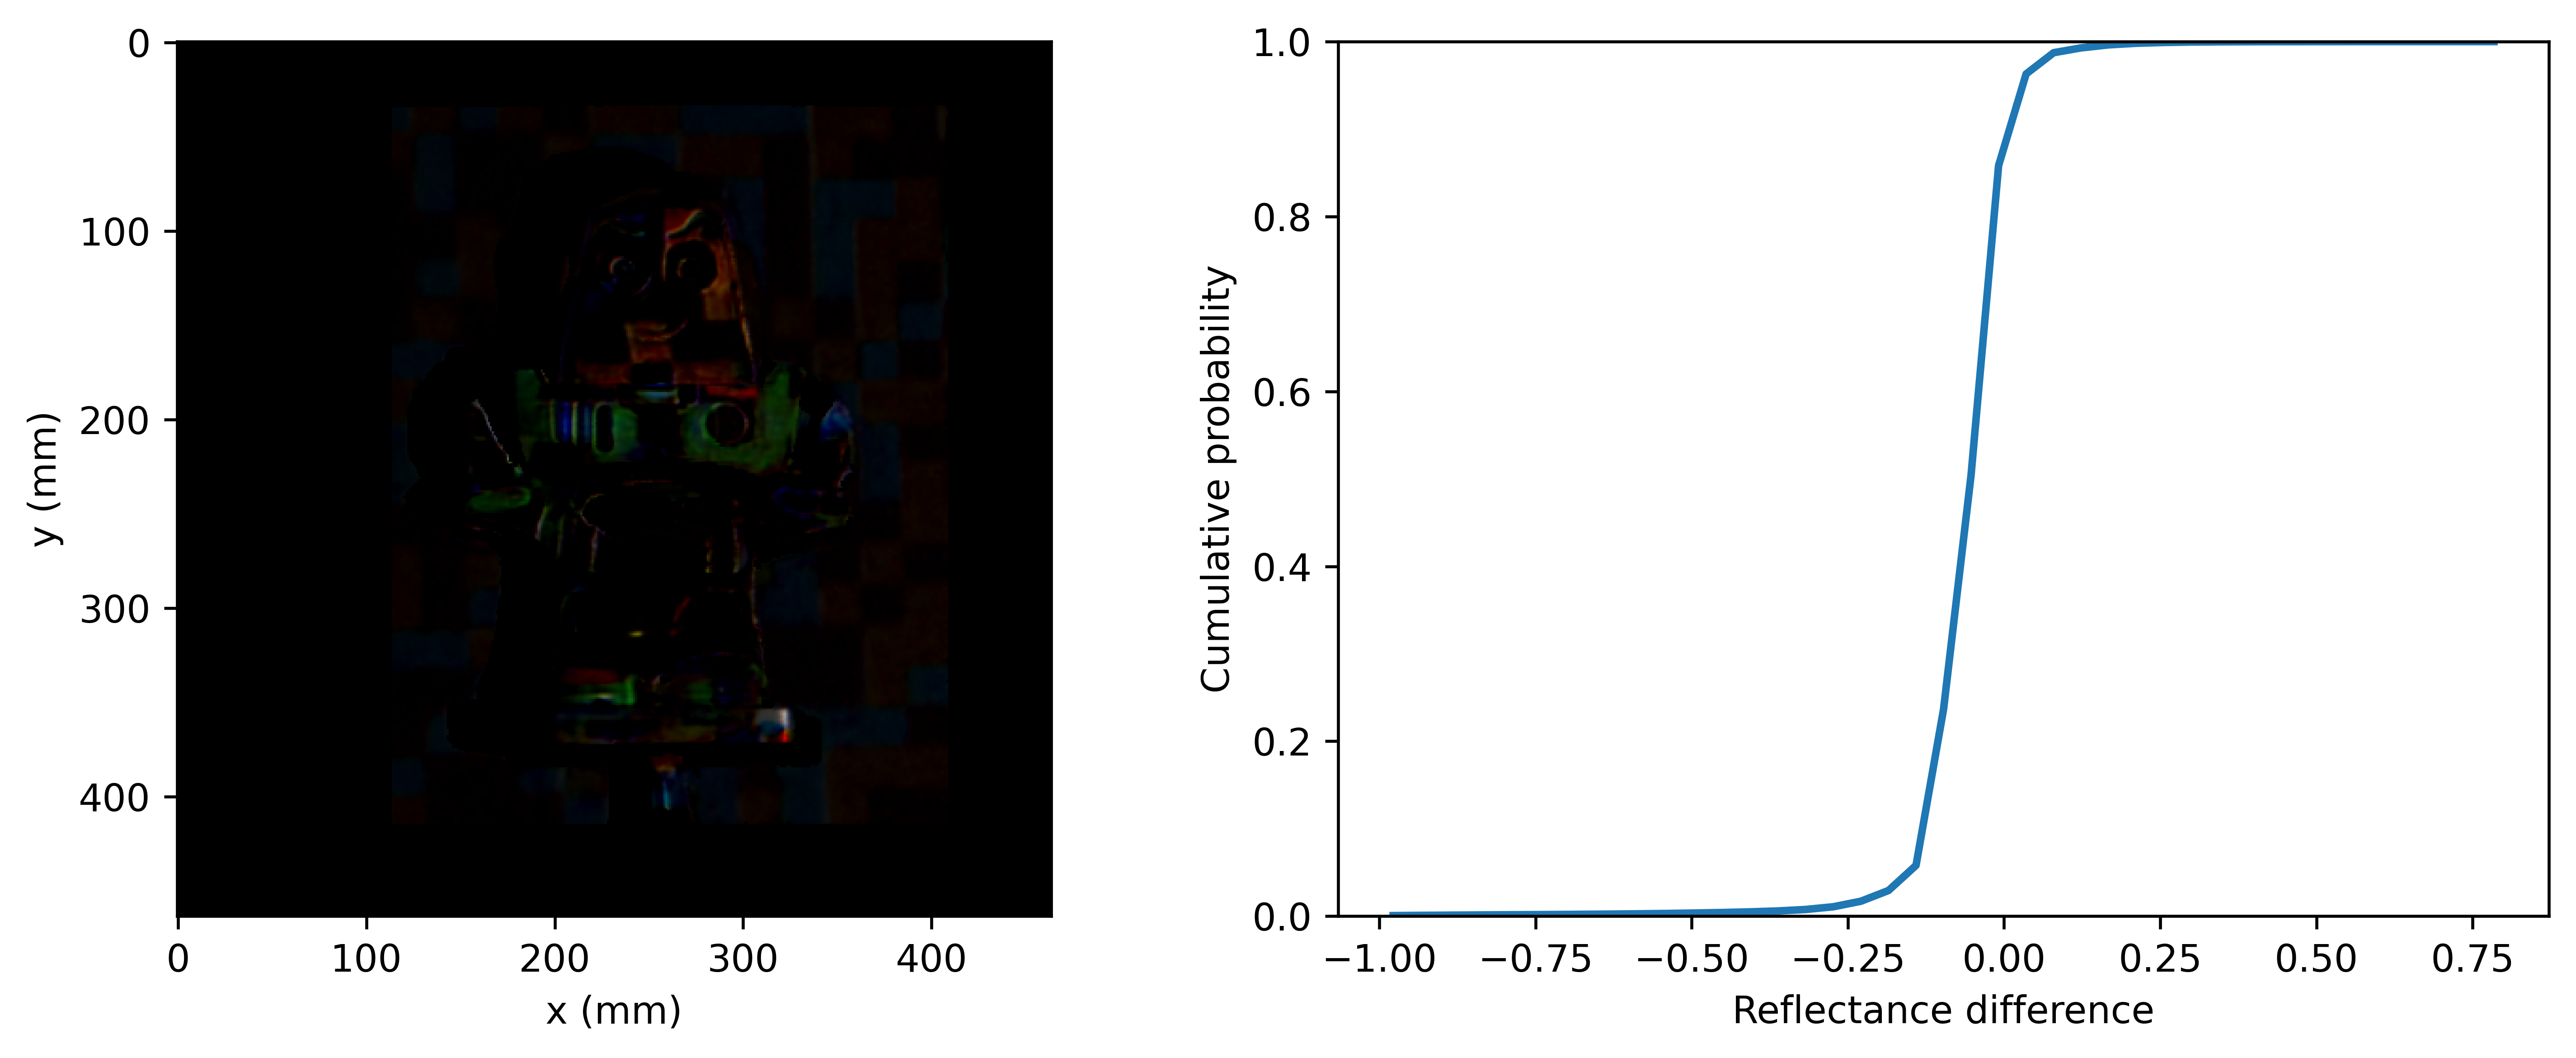

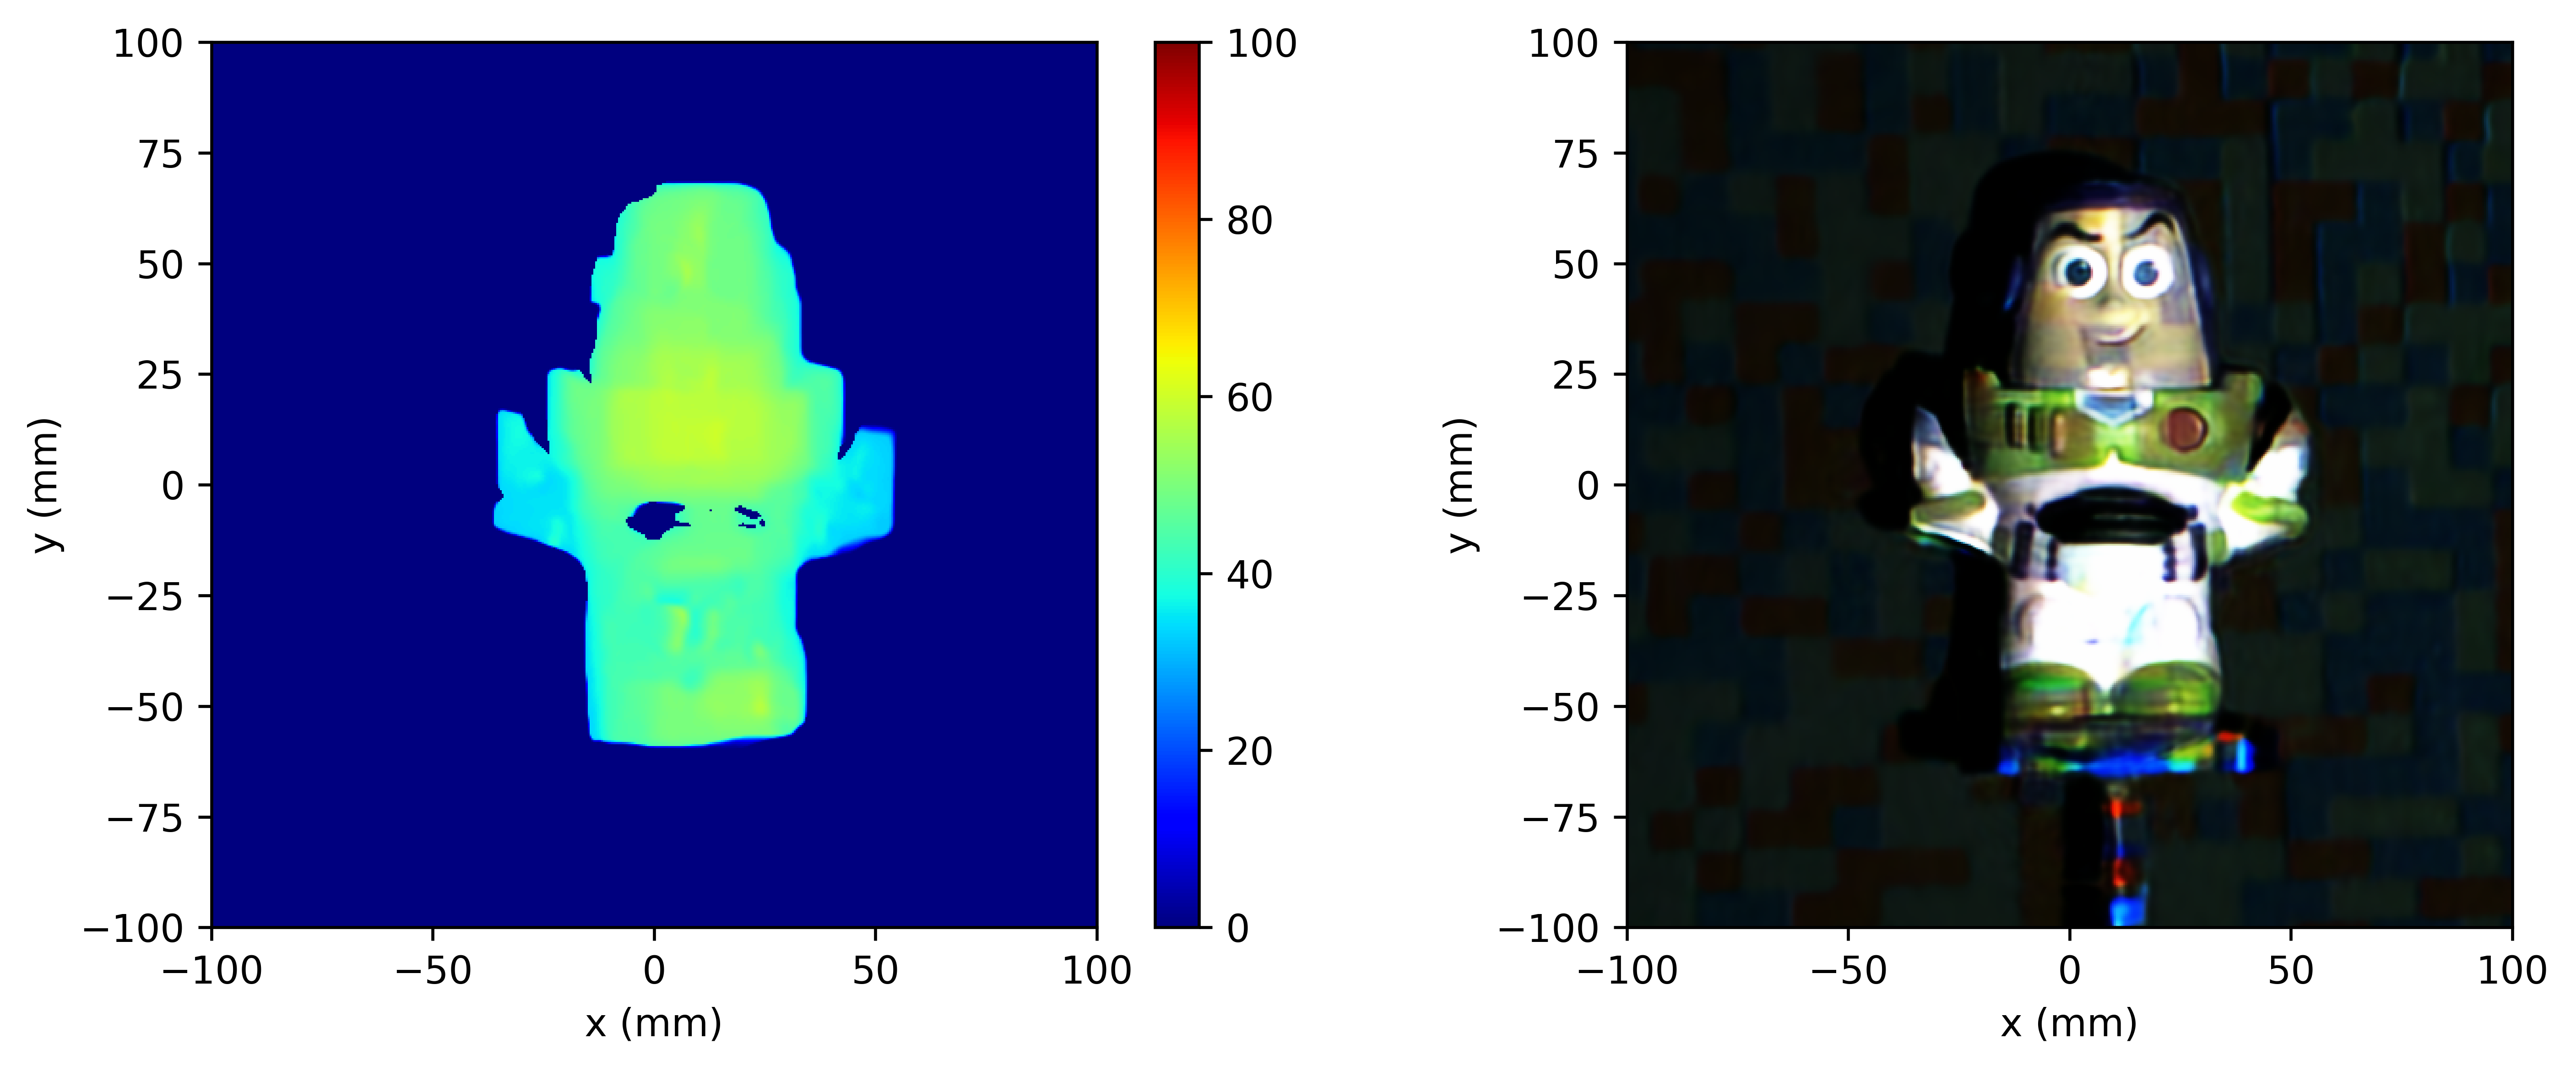

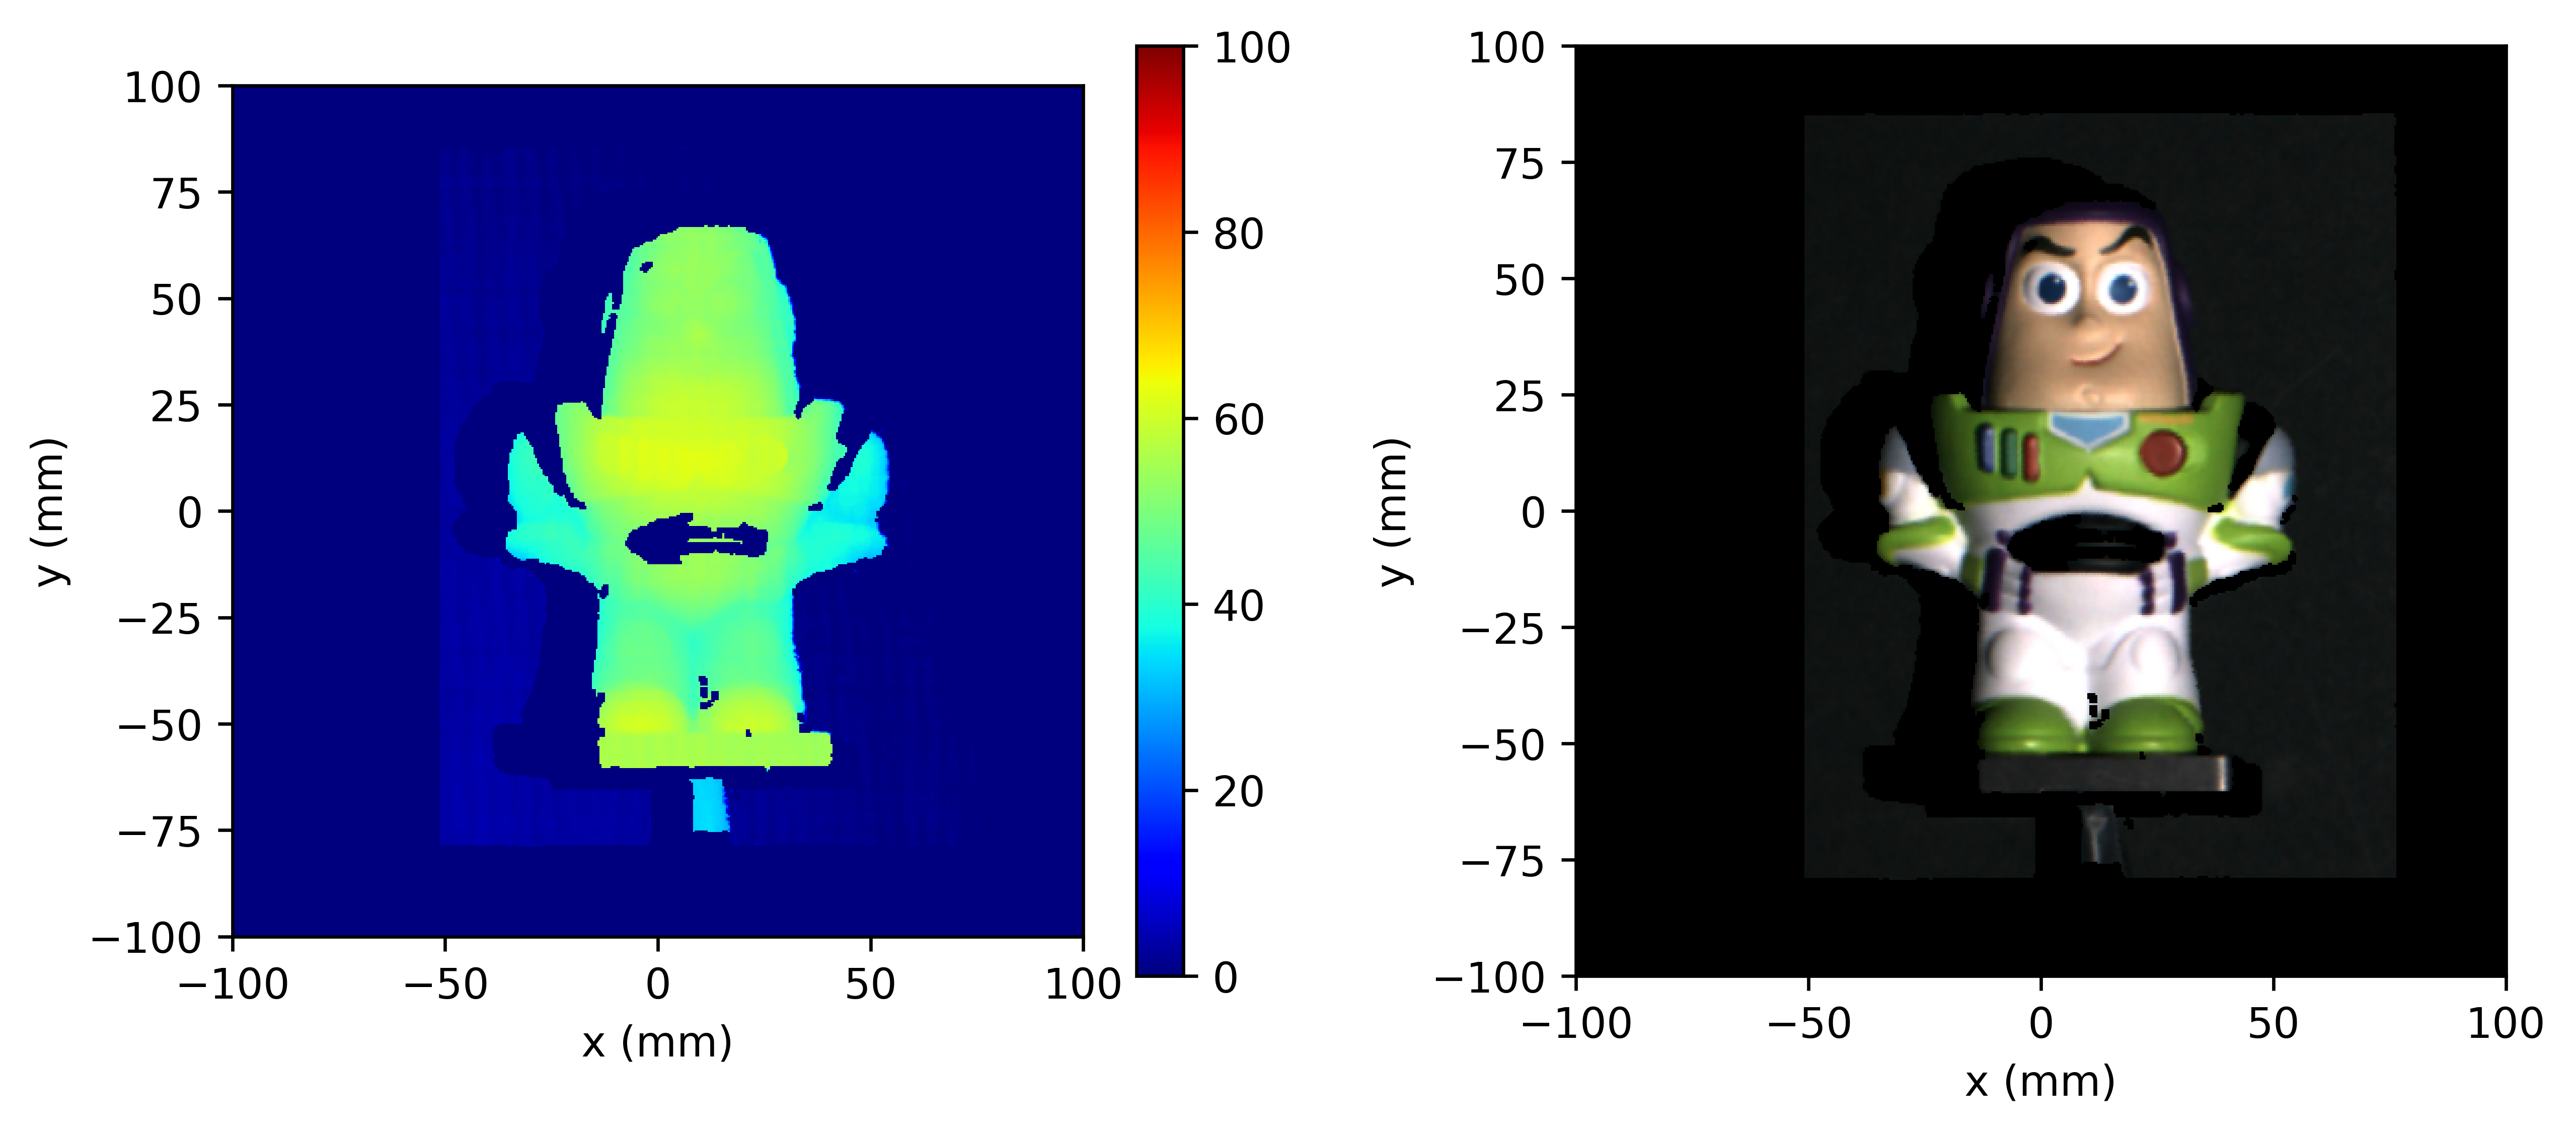

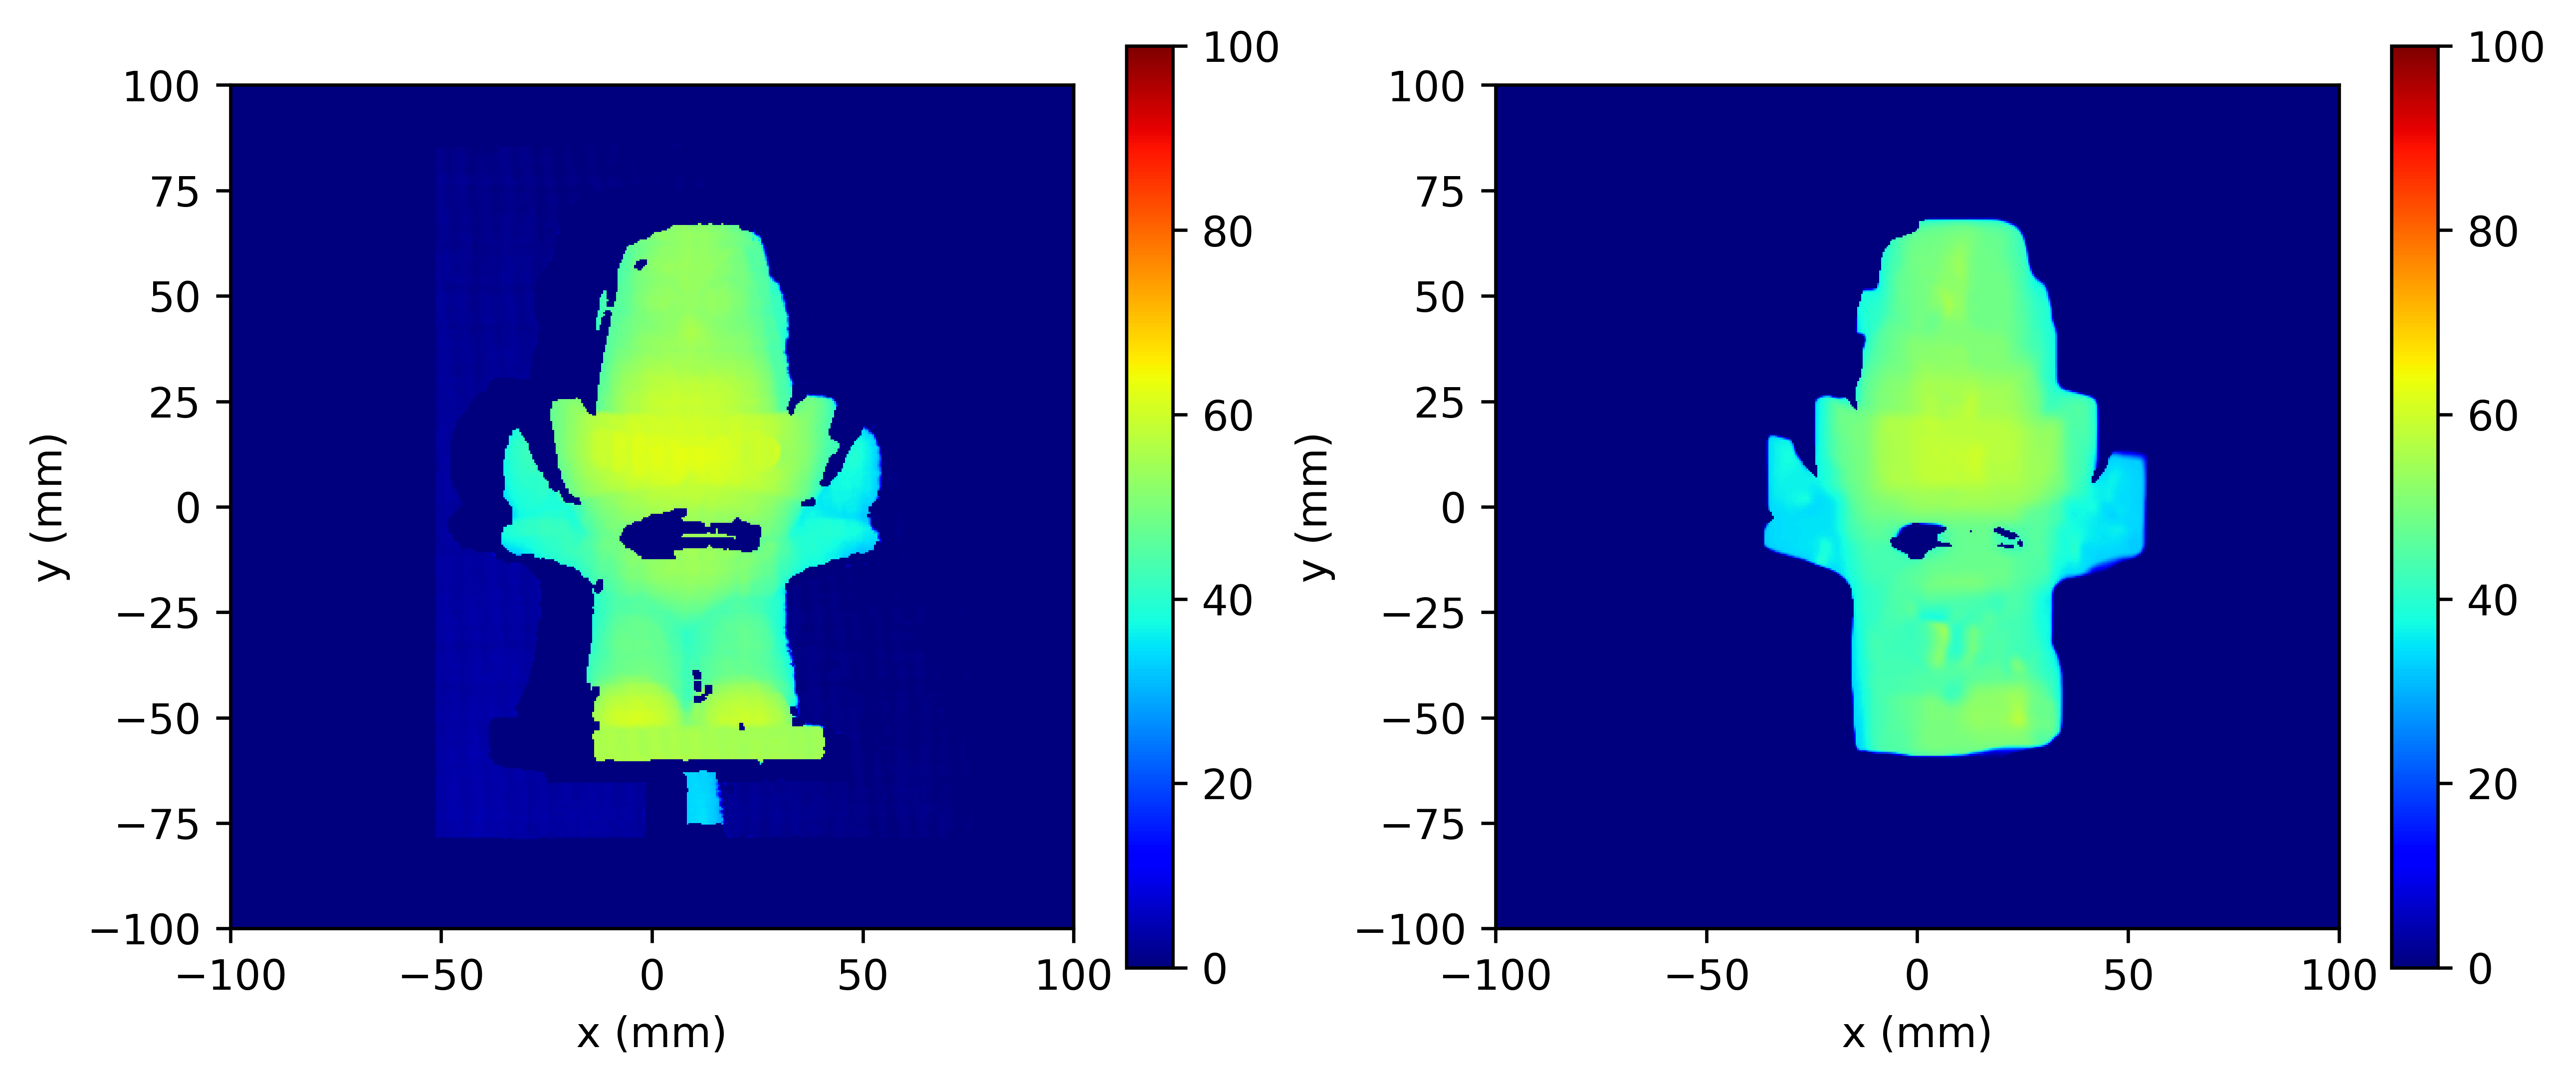

In [5]:
_ = save_and_plot_height_reflectance(
    obj_name='Buzz',
    data_path='./NN_train_results/Buzz/',
    ref_path = './Reference_data/Buzz/',
    img_size=img_size,
    extent=extent,
)